<a href="https://colab.research.google.com/github/1289nav/Exploring-chain-of-thought-reasoning-in-LLMs/blob/main/Investigating_CoT_determinism_and_faithfullness_V2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.5 MB/s eta 0:00:00


In [ ]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.6 MB/s eta 0:00:00


In [ ]:
#General system functions
import os
import sys
from pathlib import Path
from tqdm import tqdm

# String computation functions
import re

#Libraries on handling arrays, datasets and dataframes
import pandas as pd
import einops
import numpy as np
import torch as t
import datasets
import torch.nn as nn

#Other computation functions
import random

#Handling plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import jaccard_score
import Levenshtein

#Handling of string to lists formats
import ast
import json



##0.1 Setup - Deep Seek R1

Deepseek R1 LLaMA 3.1 8B distill will be used for this experiment. The given model is selected due to its good performance on most reasoning tasks while retaining the lean nature of distill models.

In [ ]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")
model = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

##0.2 Setup- Dataset

Both train and test set will be used. Train set would likely be already included in the models training data and hence first a base case will be obtained to understand robustness to CoT perturbations.

Following this for generalization test set will be used and trend further understood and robustness to CoT perturbations

In [ ]:
from datasets import load_dataset

gsm8k_ds = load_dataset("openai/gsm8k", "main")
gsm8k_ds_test = gsm8k_ds["test"]

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

## 0.3 Placeholder functions

In [ ]:
def analyze_reasoning_confidence(*args, **kwargs):
    """Placeholder function to avoid reference errors."""
    pass

In [ ]:
def compute_stepwise_backtracking_ratio(*args,**kwargs):
  pass

#1. CoT Determinisim


The following test will primarily analyze how faithful the CoT process is to the model's final answer. 3 types of tests will primarily be conducted to given an intuition and understand if further understanding of internal comptation is necessary.

- Firstly the CoT process will be rerun for several runs and results compared to test for determinism of model runs.
- Secondly the model will be given truncated CoT steps with varying degress of truncation to understand how consistent is the model on reasoning process.
- Thirdly the CoT steps may be shuffled (truncating the last answer step) to understand if the model retains its CoT capabilities inspite of noisy input and incorrect user feedback.

In [ ]:
print(model.device)
model.to(device)
print(model.device)

cpu
cuda:0


##Experiment 1.1 - Determinism on rerun

from google.colab import runtime

runtime.unassign()

In [ ]:
# Function to extract numeric answer from text
def extract_number(text):
    if not text:
        return None

    # Find all numerical values (with optional commas and decimals)
    matches = re.findall(r"\b\d{1,3}(?:,\d{3})*(?:\.\d+)?\b", text)

    if matches:
        # Remove commas and convert to float/int as needed
        extracted = matches[-1].replace(",", "")  # Take last number
        return float(extracted) if "." in extracted else int(extracted)

    return None

# Function to find answer generated by the CoT
def generate_cot_answer(steps):
  for step in reversed(steps):
    number = extract_number(step)
    if number is not None:
      return number
  return None  # No number found

### CoT generation for model
The Deep seek R1 model will be run once for several reruns and the results stored in CSV and JSON format for use in experiments and data analysis. This step could be repeated for multiple datasets for use in further experiments and plots



In [ ]:
# Function to generate CoT-based answer
def generate_cot_withatt(question,with_logits=False,with_att=False):
    # The original prompt as per the DeepSeek R1 paper in training data is used for consistency
    cot_prompt = (
        f"A conversation between User and Assistant. The user asks a question, and the Assistant solves it.",
        f"The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.",
        f"The reasoning process and answer are enclosed within <think> </think> and ",
        f"<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think> ",
        f"<answer> answer here </answer>.",
        f" The final answer must be a numeric or a decimal. ",
        f"User: {question}. Assistant: "
    )

    cot_prompt = " ".join(cot_prompt)

    inputs = tokenizer(cot_prompt, return_tensors="pt")
    inputs.to(device)
    with t.no_grad():
        if with_logits==True:
          if with_att==True:
            output = model.generate(**inputs, max_length=512, return_dict_in_generate=True, output_attentions=True,output_scores=True,return_legacy_cache=True)
            answer_text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
            attentions = output.attentions
          else:
            output = model.generate(**inputs, return_dict_in_generate=True, output_scores=True, max_length=512)
            answer_text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
        else:
          if with_att==True:
            output = model.generate(**inputs, max_length=1024, return_dict_in_generate=True, output_attentions=True)
            answer_text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
            attentions = output.attentions
          else:
            output = model.generate(**inputs, max_length=512)
            answer_text = tokenizer.decode(output[0],skip_special_tokens=True)
            generated_tokens = output[0]

    match = re.search(r"Assistant:\s*(.*)", answer_text, re.DOTALL)

    if not match:
        return []  # Return empty if no match is found

    asst_response = match.group(1).strip()

    #Remove uncessecarry symbols(LATEX) or anything after </think>
    asst_response = re.sub(r"(\*\*|\\\[|\\\])", "", asst_response)
    asst_response = re.split(r"</think>", asst_response, 1)[0].strip()

    steps = re.split(r"(?<=[.!?])\s+", asst_response)

    # Remove empty steps and strip spaces
    steps = [step.strip() for step in steps if step.strip()]

    if with_logits==True:
      logits = output.scores
      confidence_results = analyze_reasoning_confidence(logits, output.sequences , tokenizer,inputs)
    else:
      confidence_results=None

    if with_att==True:
      avg_backratios_per_step = compute_stepwise_backtracking_ratio(attentions, output.sequences , tokenizer, inputs, k=5)

    else:
      avg_backratios_per_step = None


    return steps,confidence_results,avg_backratios_per_step

In [ ]:
def run_cot_with_att(dset: list, csv_path: str, num_runs, total, with_logits=False,with_att = False):
    correct_counts = [0] * num_runs
    cot_results = []

    write_headers = not os.path.exists(csv_path)

    for k in tqdm(range(num_runs)):
        run_results = []
        for i in tqdm(range(total)):
            question = dset[i]["question"]
            true_answer = extract_number(dset[i]["answer"])
            gen_cot,conf_res,bratio_step = generate_cot_withatt(question,with_logits,with_att)  # Generates a step-by-step CoT

            model_answer = generate_cot_answer(gen_cot)  # Gets the final answer

            # Check correctness
            is_correct = (true_answer == model_answer)
            if is_correct:
                correct_counts[k] += 1

            # Store response
            run_results.append({
                "run_id": k + 1,
                "sample_id": i + 1,
                "question": question,
                "answer_response": dset[i]["answer"],
                "cot_generated": gen_cot,  # Nested list format
                "ground_truth": true_answer,
                "cot_response": model_answer,
                "is_correct": is_correct,
                "conf_per_step":conf_res,
                "bratio_per_step":bratio_step
            })

        cot_results.append(run_results)
        df = pd.DataFrame(run_results)
        df.to_csv(csv_path, mode="a", header=write_headers, index=False)
        write_headers = False  # Ensure headers are written only once

    # Compute and print accuracy per run
    accuracies = [correct / total for correct in correct_counts]
    for k, acc in enumerate(accuracies):
        print(f"Run {k+1} Accuracy: {acc:.2%}")

    return df, accuracies

In [ ]:
# File paths in Google Drive
csv_path = "/content/drive/MyDrive/AI Assignment/MATS- Neel Nanda/Spring 2025/CoT Store/GSM8K/cot_rerun_results.xlsx"

# Check if JSON file exists
if os.path.exists(csv_path):
    print("File already exists. Loading previous results...")
    df_gsm8k = pd.read_excel(csv_path)

    print(df_gsm8k.head())  # Show first few rows
else:
    print("No existing file found. Running CoT reasoning...")
    df_gsm8k = run_cot_with_att(gsm8k_ds_test,csv_path,num_runs=2,total=2,with_logits=True,with_att=True)



File already exists. Loading previous results...
   run_id  sample_id                                           question  \
0       1          1  Janet’s ducks lay 16 eggs per day. She eats th...   
1       1          2  A robe takes 2 bolts of blue fiber and half th...   
2       1          3  Josh decides to try flipping a house.  He buys...   
3       1          4  James decides to run 3 sprints 3 times a week....   
4       1          5  Every day, Wendi feeds each of her chickens th...   

                                     answer_response  \
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...   
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...   
2  The cost of the house and repairs came out to ...   
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...   
4  If each chicken eats 3 cups of feed per day, t...   

                                       cot_generated  ground_truth  \
0  ['Janet has 16 eggs per day.', 'She uses 3 for...            18   
1  ['The robe takes 2 b

### Accuraccy computation

In [ ]:
# Calculate accuracy per run_id
accuracy_df = df_gsm8k.groupby('run_id')['is_correct'].mean().reset_index()
accuracy_df.rename(columns={'is_correct': 'accuracy'}, inplace=True)

# Convert accuracy to percentage
accuracy_df['accuracy'] = (accuracy_df['accuracy'] * 100).round(2)

# Print the result
print(accuracy_df)

   run_id  accuracy
0       1      65.0
1       2      62.0
2       3      64.0
3       4      68.0
4       5      59.0
5       6      62.0
6       7      63.0
7       8      60.0


### Jaccard Similarity and Edit distance-Violin plots

In [ ]:
# Function to compute Jaccard similarity
def jaccard_similarity(str1, str2):
    tokens1 = set(tokenizer.tokenize(str1))
    tokens2 = set(tokenizer.tokenize(str2))
    return len(tokens1 & tokens2) / len(tokens1 | tokens2) if tokens1 | tokens2 else 0

# Compute Jaccard similarity between runs for the same question
jaccard_data = []
for sample_id in df_gsm8k["sample_id"].unique():
    subset = df_gsm8k[df_gsm8k["sample_id"] == sample_id].sort_values("run_id")
    cot_responses = subset["cot_generated"].tolist()

    if len(cot_responses) < 2:
        continue  # Skip if there's only one run for a question

    # Compute Jaccard similarity for every pair of runs
    for i in range(len(cot_responses)):
      j = i+1
      while j<len(cot_responses):
        jaccard = jaccard_similarity(" ".join(cot_responses[i])," ".join(cot_responses[j]))
        edit_dist = Levenshtein.distance(" ".join(cot_responses[i]), " ".join(cot_responses[j]))

        jaccard_data.append({
            "sample_id": sample_id,
            "run_comparison": f"Run {i+1} vs Run {j+1}",
            "jaccard_similarity": jaccard,
            "edit_distance": edit_dist
        })
        j +=1

# Convert to DataFrame
jaccard_df = pd.DataFrame(jaccard_data)

print(jaccard_df.head())




   sample_id  run_comparison  jaccard_similarity  edit_distance
0          1  Run 1 vs Run 2            0.840000            211
1          1  Run 1 vs Run 3            0.833333            640
2          1  Run 1 vs Run 4            0.880000            156
3          1  Run 1 vs Run 5            0.862745            440
4          1  Run 1 vs Run 6            0.880000            615


<ipython-input-17-c785a6fa0d50>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=jaccard_df["jaccard_similarity"], inner="quartile", palette="muted")


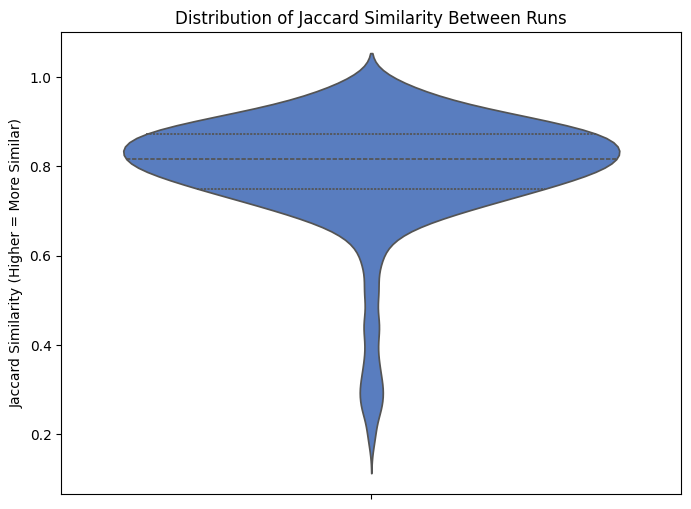

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(y=jaccard_df["jaccard_similarity"], inner="quartile", palette="muted")
plt.title("Distribution of Jaccard Similarity Between Runs")
plt.ylabel("Jaccard Similarity (Higher = More Similar)")
plt.show()


<ipython-input-18-a166f7447efb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=jaccard_df["edit_distance"], inner="quartile", palette="muted")


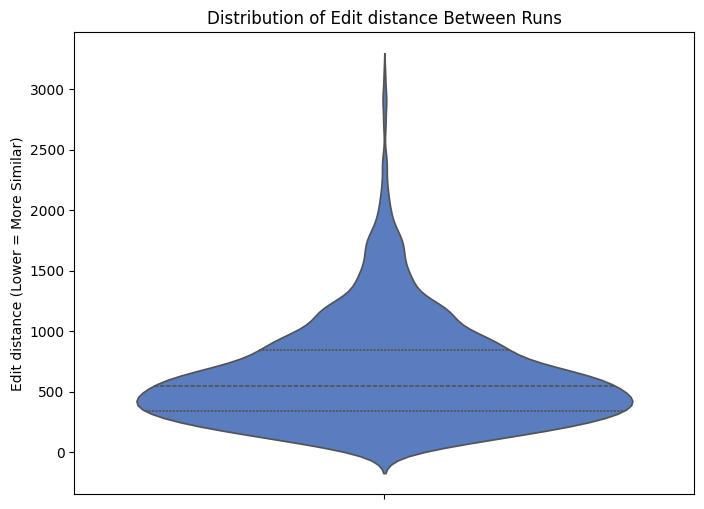

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(y=jaccard_df["edit_distance"], inner="quartile", palette="muted")
plt.title("Distribution of Edit distance Between Runs")
plt.ylabel("Edit distance (Lower = More Similar)")
plt.show()

##Experiment 1.2 - Determinism on CoT truncation

In [ ]:
# Safely convert string representations of lists into actual lists
df_gsm8k["cot_generated"] = df_gsm8k["cot_generated"].apply(ast.literal_eval)

# Verify the conversion
print(type(df_gsm8k["cot_generated"].iloc[0]))  # Should be <class 'list'>
print(df_gsm8k["cot_generated"].head())


<class 'list'>
0    [Janet has 16 eggs per day., She uses 3 for br...
1    [The robe takes 2 bolts of blue fiber and half...
2    [Josh bought a house for $80,000., He spent an...
3    [James runs 3 sprints each week, and each spri...
4    [Wendi feeds her flock of 20 chickens with mix...
Name: cot_generated, dtype: object


In [ ]:
def truncate_cot(cot_list, fraction=0.5):
    """
    Truncates the CoT reasoning steps to a given fraction.

    Parameters:
    - cot_list (list): List of CoT reasoning steps.
    - fraction (float): The percentage of steps to keep (0 to 1).

    Returns:
    - list: Truncated CoT list.
    """
    if not isinstance(cot_list, list) or not cot_list:
        return cot_list  # Return as-is if empty or not a list

    num_steps_to_keep = max(1, int(len(cot_list) * fraction))  # Ensure at least one step
    return cot_list[:num_steps_to_keep]  # Return truncated list


### CoT generation

In [ ]:
def evaluate_truncated_cot(question, full_cot, model, tokenizer, fraction):
    """
    Evaluates model accuracy with truncated CoT.

    Parameters:
    - question (str): The original question.
    - full_cot (str): The full CoT reasoning.
    - model, tokenizer: The language model and tokenizer.
    - fraction (float): How much CoT to keep.

    Returns:
    - str: Model's answer after continuing from truncated CoT.
    """
    truncated_cot = truncate_cot(full_cot, fraction)
    cot_prompt = (
    f"A conversation between User and Assistant. The user asks a question, and the Assistant solves it.",
    f"The Assistant is given a partial reasoning process and must complete it in a step-by-step manner.",
    f"The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively.",
    f"The Assistant must not skip steps but instead explicitly show all calculations before arriving at the answer.",
    f"The final answer must be a numeric or decimal. ",
    f"User: {question}. Reasoning process: {truncated_cot}. Assistant: "
    )


    prompt = " ".join(cot_prompt)
    inputs = tokenizer(prompt, return_tensors="pt",truncation=True,max_length=1024)
    inputs.to(device)
    output = model.generate(**inputs, max_new_tokens=1024)

    answer_text = tokenizer.decode(output[0], skip_special_tokens=True)

    """
    match = re.search(r"Assistant:\s*(.*)", answer_text, re.DOTALL)

    if not match:
        return []  # Return empty if no match is found

    asst_response = match.group(1).strip()
    steps = re.split(r"(?<=[.!?])\s+", asst_response)

    # Remove empty steps and strip spaces
    steps = [step.strip() for step in steps if step.strip()]
    """

    return answer_text

In [ ]:
def run_cot_from_trunc(dset: list, csv_path_trunc: str, truncation_levels, selected_run_id=1):
  df_selected = dset[dset["run_id"] == selected_run_id]
  write_headers = not os.path.exists(csv_path_trunc)  # Check if file exists
  results = {}

  for fraction in tqdm(truncation_levels, desc="Processing Truncation Levels"):
    correct = 0
    total = len(df_selected)
    for i, row in tqdm(df_selected.iterrows(), total=total, desc=f"Truncation {fraction*100}%"):
        question = row["question"]
        full_cot = row["cot_generated"]  # Use stored CoT reasoning
        truncated_answer = evaluate_truncated_cot(question, full_cot, model, tokenizer, fraction)
        true_answer = row["ground_truth"]
        model_answer = row["model_answer"]
        model_answer_trunc = extract_number(truncated_answer)

        if true_answer and model_answer and true_answer == model_answer:
            correct += 1

        # Create DataFrame for this single row
        df_trunc_result = pd.DataFrame([{
            "truncation_fraction": fraction,
            "question": question,
            "full_cot": full_cot,
            "model_answer_completion":truncated_answer,
            "true_answer": true_answer,
            "model_answer": model_answer,
            "model_answer_trunc": model_answer_trunc
        }])

        # Save incrementally
        df_trunc_result.to_csv(csv_path_trunc, mode="a", header=write_headers, index=False)
        write_headers = False  # Ensure headers are written only once

    accuracy = correct / total if total > 0 else 0
    results[f"Truncation {fraction*100}%"] = accuracy
    print(f"Saved truncation {fraction*100}% results to {csv_path_trunc}")

In [ ]:
truncation_levels = [0.25, 0.5, 0.75]
selected_run_id = 1
csv_path_trunc="/content/drive/MyDrive/AI Assignment/MATS- Neel Nanda/Spring 2025/CoT Store/GSM8K/cot_trunc_res.xlsx"

# Check if JSON file exists
if os.path.exists(csv_path_trunc):
    print("File already exists. Loading previous results...")
    df_gsm8k_trunc = pd.read_excel(csv_path_trunc)

    print(df_gsm8k_trunc.head())  # Show first few rows
else:
    print("No existing file found. Running CoT reasoning...")
    df_gsm8k_trunc = run_cot_from_trunc(gsm8k_ds_test,csv_path_trunc,truncation_levels,selected_run_id)


File already exists. Loading previous results...
   sample_id  truncation_fraction  \
0          1               0.0625   
1          2               0.0625   
2          3               0.0625   
3          4               0.0625   
4          5               0.0625   

                                            question  \
0  Janet’s ducks lay 16 eggs per day. She eats th...   
1  A robe takes 2 bolts of blue fiber and half th...   
2  Josh decides to try flipping a house.  He buys...   
3  James decides to run 3 sprints 3 times a week....   
4  Every day, Wendi feeds each of her chickens th...   

                                            full_cot  \
0  ['Janet has 16 eggs per day.', 'She uses 3 for...   
1  ['The robe takes 2 bolts of blue fiber and hal...   
2  ['Josh bought a house for $80,000.', 'He spent...   
3  ['James runs 3 sprints each week, and each spr...   
4  ['Wendi feeds her flock of 20 chickens with mi...   

                                       truncated_cot  

### Accuraccy and plotting

In [ ]:
df_gsm8k_trunc["is_correct"] = df_gsm8k_trunc["model_answer_trunc"]==df_gsm8k_trunc["true_answer"]

print(df_gsm8k_trunc.head)

<bound method NDFrame.head of      sample_id  truncation_fraction  \
0            1               0.0625   
1            2               0.0625   
2            3               0.0625   
3            4               0.0625   
4            5               0.0625   
..         ...                  ...   
295         96               0.5625   
296         97               0.5625   
297         98               0.5625   
298         99               0.5625   
299        100               0.5625   

                                              question  \
0    Janet’s ducks lay 16 eggs per day. She eats th...   
1    A robe takes 2 bolts of blue fiber and half th...   
2    Josh decides to try flipping a house.  He buys...   
3    James decides to run 3 sprints 3 times a week....   
4    Every day, Wendi feeds each of her chickens th...   
..                                                 ...   
295  Out of the 200 Grade 5 students, 2/5 are boys ...   
296  Harry slept 9 hours last night. 

In [ ]:
# Calculate accuracy per run_id
accuracy_df_trunc = df_gsm8k_trunc.groupby('truncation_fraction')['is_correct'].mean().reset_index()
accuracy_df_trunc.rename(columns={'is_correct': 'accuracy'}, inplace=True)

# Convert accuracy to percentage
accuracy_df_trunc['accuracy'] = (accuracy_df_trunc['accuracy'] * 100).round(2)

# Print the result
print(accuracy_df_trunc)

   truncation_fraction  accuracy
0               0.0625      56.0
1               0.2500      32.0
2               0.5625      31.0


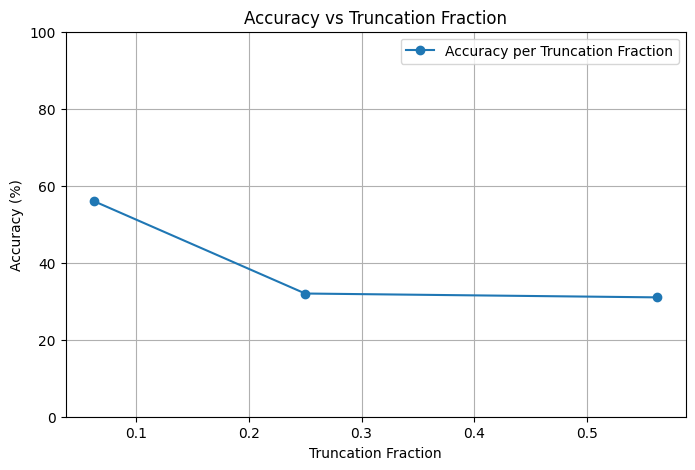

In [ ]:
# Plot accuracy vs truncation_fraction
plt.figure(figsize=(8, 5))
plt.plot(accuracy_df_trunc['truncation_fraction'], accuracy_df_trunc['accuracy'], marker='o', linestyle='-', label='Accuracy per Truncation Fraction')
plt.xlabel('Truncation Fraction')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Truncation Fraction')
plt.ylim(0, 100)
plt.legend()
plt.grid()
plt.show()


In [ ]:
df_gsm8k_trunc["is_correct_change"] = df_gsm8k_trunc["model_answer_trunc"]==df_gsm8k_trunc["model_answer"]

print(df_gsm8k_trunc.head)

<bound method NDFrame.head of      sample_id  truncation_fraction  \
0            1               0.0625   
1            2               0.0625   
2            3               0.0625   
3            4               0.0625   
4            5               0.0625   
..         ...                  ...   
295         96               0.5625   
296         97               0.5625   
297         98               0.5625   
298         99               0.5625   
299        100               0.5625   

                                              question  \
0    Janet’s ducks lay 16 eggs per day. She eats th...   
1    A robe takes 2 bolts of blue fiber and half th...   
2    Josh decides to try flipping a house.  He buys...   
3    James decides to run 3 sprints 3 times a week....   
4    Every day, Wendi feeds each of her chickens th...   
..                                                 ...   
295  Out of the 200 Grade 5 students, 2/5 are boys ...   
296  Harry slept 9 hours last night. 

In [ ]:
# Calculate accuracy per run_id
accuracy_df_trunc_2 = df_gsm8k_trunc.groupby('truncation_fraction')['is_correct_change'].mean().reset_index()
accuracy_df_trunc_2.rename(columns={'is_correct_change': 'agreement'}, inplace=True)

# Convert accuracy to percentage
accuracy_df_trunc_2['agreement'] = (accuracy_df_trunc_2['agreement'] * 100).round(2)

# Print the result
print(accuracy_df_trunc_2)

   truncation_fraction  agreement
0               0.0625       54.0
1               0.2500       33.0
2               0.5625       35.0


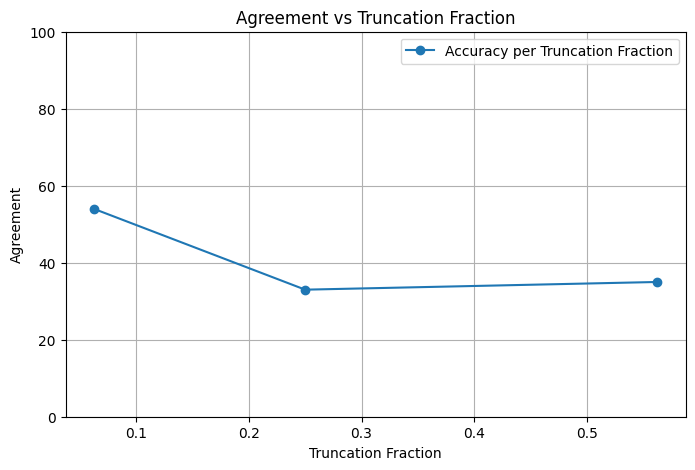

In [ ]:
# Plot accuracy vs truncation_fraction
plt.figure(figsize=(8, 5))
plt.plot(accuracy_df_trunc_2['truncation_fraction'], accuracy_df_trunc_2['agreement'], marker='o', linestyle='-', label='Agreement per Truncation Fraction')
plt.xlabel('Truncation Fraction')
plt.ylabel('Agreement')
plt.title('Agreement vs Truncation Fraction')
plt.ylim(0, 100)
plt.legend()
plt.grid()
plt.show()


#2. CoT faithfullness- Black box approach

## 2.1 Editing CoT computations

In [ ]:
def sample_log_uniform(low, high, size):
    return np.exp(np.random.uniform(np.log(low), np.log(high), size))

def stratified_sampling(num_samples_per_bin):
    bins = {
        "low_noise": sample_log_uniform(0.01, 0.05, num_samples_per_bin),
        "medium_noise": sample_log_uniform(0.05, 0.12, num_samples_per_bin),
        "high_noise": sample_log_uniform(0.12, 0.25, num_samples_per_bin),
    }
    return bins

def compute_final_error(base_value, noisy_value):
    if base_value == 0:
        return None
    return abs(base_value - noisy_value) / base_value

In [ ]:
# Adaptive resampling based on variance
def adaptive_resampling(errors, threshold=0.05, base_samples=5, max_extra=20):
    additional_samples = {}

    for key, error_list in errors.items():
        if len(error_list) < 2:
            continue  # Not enough data to compute variance

        variance = np.var(error_list)

        if variance > threshold:
            # Scale extra samples based on variance intensity
            extra = min(base_samples + int(variance * 100), max_extra)
            additional_samples[key] = extra
        else:
            additional_samples[key] = 0  # Skip stable bins

    return additional_samples

In [ ]:
def apply_noise_to_cot_steps(cot_steps, noise_factor):
    def add_noise(match):
        num = float(match.group())
        noisy_num = num + (num * noise_factor)  # Add noise proportionally

        # Preserve integer format if the original number was an integer
        if "." not in match.group():
            return str(round(noisy_num))
        else:
            return f"{noisy_num:.3f}"  # Keep three decimal places for floats

    def apply_noise_to_step(step):
        return re.sub(r"\d+\.?\d*", add_noise, step)  # Replace all numeric values in the string

    # Ensure cot_steps is a list of full steps, not characters
    if isinstance(cot_steps, list) and all(isinstance(step, str) for step in cot_steps):
        return [apply_noise_to_step(step) for step in cot_steps]

    elif isinstance(cot_steps, list) and all(isinstance(step_list, list) for step_list in cot_steps):
        return [[apply_noise_to_step(step) for step in step_list] for step_list in cot_steps]

    else:
        raise ValueError("cot_steps must be a list of strings or a list of lists of strings")



In [ ]:
# Assign noise bin
def assign_bin(noise_factor):
    if noise_factor < 0.05:
        return "low_noise"
    elif noise_factor < 0.12:
        return "medium_noise"
    return "high_noise"

In [ ]:
def extract_last_number(text):
    # Find all numbers (integer or decimal) in the text
    numbers = re.findall(r"\d+\.\d+|\d+", text)

    if not numbers:
        return None  # No numbers found

    # Convert to float (handles both integers and decimals)
    return float(numbers[-1])


### Running CoT

In [ ]:
# Main function
def run_cot_from_trunc_with_noise(dset, csv_path_trunc_noise,selected_run_id=1,initial_samples=100, reruns=5, truncation_levels=[0.33, 0.5, 0.75]):
    # Check if CSV exists
    df = dset[dset["run_id"] == selected_run_id]
    write_headers = not os.path.exists(csv_path_trunc_noise)

    for trunc in truncation_levels:
        print(f"Running for truncation level: {trunc*100}%")

        # Shuffle samples
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)

        # Initial stratified sampling
        stratified_samples = stratified_sampling(initial_samples // 3)
        errors = {key: [] for key in stratified_samples.keys()}
        init_noise = sample_log_uniform(0.01, 0.25, 100)

        # Run initial perturbation experiment
        for i, row in tqdm(df.iterrows()):
            full_cot = row["cot_generated"]
            question = row["question"]
            true_answer = row["ground_truth"]

            noise_factor = init_noise[i]
            noisy_cot = apply_noise_to_cot_steps(full_cot, noise_factor)
            truncated_answer = evaluate_truncated_cot(question, noisy_cot, model, tokenizer, trunc)

            model_answer = row["cot_response"]
            model_answer_trunc = extract_last_number(truncated_answer)

            error = compute_final_error(model_answer,model_answer_trunc)
            key = assign_bin(noise_factor)
            errors[key].append(error)

            # Create DataFrame for this single row

            df_trunc_result = pd.DataFrame([{
            "truncation_fraction": trunc,
            "question": question,
            "full_cot": full_cot,
            "noise_factor": noise_factor,
            "noisy_cot": noisy_cot,
            "model_answer_completion": truncated_answer,
            "true_answer": true_answer,
            "model_answer": model_answer,
            "model_answer_trunc": model_answer_trunc
             }])

            # Save incrementally
            df_trunc_result.to_csv(csv_path_trunc_noise, mode="a", header=write_headers, index=False)
            write_headers = False  # Ensure headers are written only once

        # Adaptive resampling loop
        for rerun in tqdm(range(reruns)):
            df = df.sample(frac=1, random_state=rerun).reset_index(drop=True)
            additional_samples = adaptive_resampling(errors)

            # Define noise ranges for each bucket
            bucket_ranges = {
            "low_noise": (0.01, 0.05),
            "medium_noise": (0.05, 0.12),
            "high_noise": (0.12, 0.25),
            }

            for key, extra_samples in additional_samples.items():
              if extra_samples == 0:
                continue  # Skip stable cases

              # Get noise range from the bucket
              low, high = bucket_ranges[key]

              for _ in range(extra_samples):
                i = random.randint(0, len(df) - 1)
                full_cot = df.iloc[i]["cot_generated"]
                question = df.iloc[i]["question"]
                true_answer = df.iloc[i]["ground_truth"]

                noise_factor = sample_log_uniform(low, high, 1)[0]
                noisy_cot = apply_noise_to_cot_steps(full_cot, noise_factor)
                truncated_answer = evaluate_truncated_cot(question, noisy_cot, model, tokenizer, trunc)

                model_answer = df.iloc[i]["cot_response"]
                model_answer_trunc = extract_last_number(truncated_answer)

                error = compute_final_error(model_answer,model_answer_trunc)
                errors[key].append(error)

                # Create DataFrame for this single row
                df_trunc_result = pd.DataFrame([{
                  "truncation_fraction": trunc,
                  "question": question,
                  "full_cot": full_cot,
                  "noise_factor": noise_factor,
                  "noisy_cot": noisy_cot,
                  "model_answer_completion": truncated_answer,
                  "true_answer": true_answer,
                  "model_answer": model_answer,
                  "model_answer_trunc": model_answer_trunc
                }])

                # Save incrementally
                df_trunc_result.to_csv(csv_path_trunc_noise, mode="a", header=write_headers, index=False)
                write_headers = False  # Ensure headers are written only once


In [ ]:
# Run experiment
csv_path_trunc_wnoise="/content/drive/MyDrive/AI Assignment/MATS- Neel Nanda/Spring 2025/CoT Store/GSM8K/cot_trunc_res_wnoise.xlsx"

# Check if JSON file exists
if os.path.exists(csv_path_trunc_wnoise):
    print("File already exists. Loading previous results...")
    df_gsm8k_trunc_wnoise = pd.read_excel(csv_path_trunc_wnoise)

    print(df_gsm8k_trunc_wnoise.head())  # Show first few rows
else:
    print("No existing file found. Running CoT reasoning...")
    df_gsm8k_trunc_wnoise = run_cot_from_trunc_with_noise(df_gsm8k,csv_path_trunc_wnoise)

File already exists. Loading previous results...
   truncation_fraction                                           question  \
0                 0.33  Dan plants 3 rose bushes. Each rose bush has 2...   
1                 0.33  A mechanic charges different rates to repair t...   
2                 0.33  Judy teaches 5 dance classes, every day, on th...   
3                 0.33  Meredith is a freelance blogger who writes abo...   
4                 0.33  Charlie wants to sell beeswax candles.  For ev...   

                                            full_cot  noise_factor  \
0  ['Dan plants 3 rose bushes, and each rose bush...      0.029195   
1  ['First, calculate the revenue for Thursday.',...      0.021388   
2  ['Judy teaches 5 dance classes on weekdays and...      0.122091   
3  ['First, I need to determine how many articles...      0.018976   
4  ['First, determine the number of pounds of bee...      0.150200   

                                           noisy_cot  \
0  ['Dan pl

### Scatter plots of results

In [ ]:
df_gsm8k_trunc_wnoise["percentage_difference"] = (
    abs(df_gsm8k_trunc_wnoise["model_answer_trunc"] - df_gsm8k_trunc_wnoise["model_answer"])
    / abs(df_gsm8k_trunc_wnoise["model_answer"])  # Avoid sign issues
) * 100

# Get unique truncation fractions
truncation_values = df_gsm8k_trunc_wnoise["truncation_fraction"].unique()

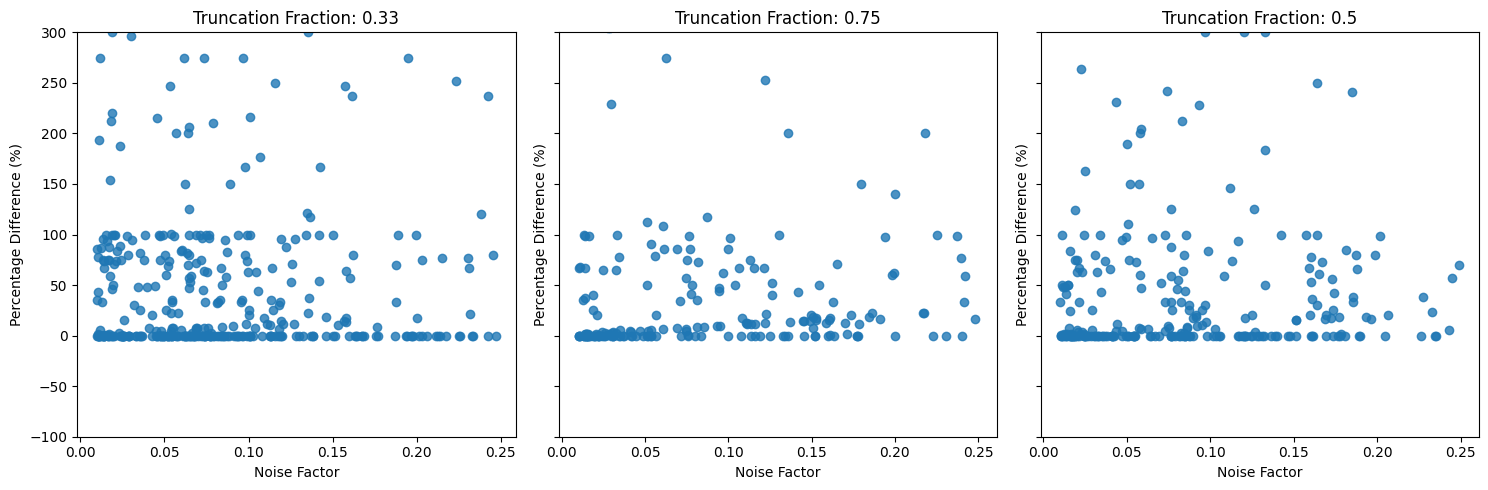

In [ ]:
# Compute IQR and filter out outliers
Q1 = df_gsm8k_trunc_wnoise["percentage_difference"].quantile(0.25)
Q3 = df_gsm8k_trunc_wnoise["percentage_difference"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds to exclude outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers to compute the max non-outlier value
filtered_df = df_gsm8k_trunc_wnoise[
    (df_gsm8k_trunc_wnoise["percentage_difference"] >= lower_bound) &
    (df_gsm8k_trunc_wnoise["percentage_difference"] <= upper_bound)
]

# Compute max percentage difference within non-outliers
m = filtered_df["percentage_difference"].max()

# Get unique truncation fractions
truncation_values = df_gsm8k_trunc_wnoise["truncation_fraction"].unique()

# Set up the plot
fig, axes = plt.subplots(1, len(truncation_values), figsize=(15, 5), sharey=True)

# Plot each scatter plot
for i, trunc in enumerate(truncation_values):
    subset = df_gsm8k_trunc_wnoise[df_gsm8k_trunc_wnoise["truncation_fraction"] == trunc]
    ax = axes[i]
    sns.regplot(x="noise_factor", y="percentage_difference", data=subset, ax=ax, scatter=True, ci=None, line_kws={"color": "red"})
    ax.set_title(f"Truncation Fraction: {trunc}")
    ax.set_xlabel("Noise Factor")
    ax.set_ylabel("Percentage Difference (%)")

    # Set y-axis limits between -100 and m+100, ensuring valid values
    ax.set_ylim(-100, min(m + 100, subset["percentage_difference"].max() + 10))  # Avoid over-stretching

plt.tight_layout()
plt.show()


#3. CoT faithfullness- White box approach

## 3.1 Stepwise confidence and trends for reasoning paths

### Computing stepwise confidence

In [ ]:
def analyze_reasoning_confidence(logits, gen_tok, tokenizer,inputs):
    """
    Analyze model confidence at each reasoning step in CoT reasoning.

    Parameters:
    - logits: Model output logits for each token.
    - generated_text: Full CoT response as a string.
    - tokenizer: Tokenizer used to decode tokens.

    Returns:
    - List of reasoning steps with their average log probabilities.
    """
    # Convert logits to probabilities

    logits = t.stack(logits, dim=1)  # Shape: (batch_size, seq_length, vocab_size)


    log_probs = t.nn.functional.log_softmax(logits, dim=-1)
    token_probs = log_probs.max(dim=-1).values  # Pick the probability of the chosen token
    # print("Token_probs_size: ",token_probs.shape)

    gen_start = inputs["input_ids"].shape[1]
    gen_tokens = gen_tok[:, gen_start:]  # Generated tokens only
    # print("Full out: ",tokenizer.decode(gen_tok[0]))
    # print("Generated part: ",tokenizer.decode(gen_tokens[0]))
    gen_text_tokens = [tokenizer.decode([tok]) for tok in gen_tokens[0]]  # Decode per token

    gen_probs = token_probs
    # print("Gen_probs shape: ",gen_probs.shape)
    # Identify reasoning steps (split by punctuation markers)
    step_markers = [".", "?", "!"]
    step_indices = [0]

    for i, token in enumerate(gen_text_tokens):
      if token.endswith(tuple(step_markers)):  # Check if the decoded token ends with punctuation
        step_indices.append(i + 1)

    # Compute confidence per step
    #print(step_indices)
    # print("Step indices: ",step_indices)
    step_confidence = []

    for i in range(len(step_indices) - 1):
        start, end = step_indices[i], step_indices[i + 1]
        if start>=end:
          continue

        # print("Step num ",i+1,": ",tokenizer.decode(gen_tokens[0,start:end]))
        avg_log_prob = gen_probs[0,start:end].mean().item()  # Average confidence

        step_confidence.append({
            "step_num": i+1,
            "avg_log_prob": avg_log_prob  # More negative → more uncertain
        })

    return step_confidence

In [ ]:
# File paths in Google Drive
csv_path_att = "/content/drive/MyDrive/AI Assignment/MATS- Neel Nanda/Spring 2025/CoT Store/GSM8K/cot_rerun_results.xlsx"

# Check if CSV file exists
if os.path.exists(csv_path_att):
    print("File already exists. Loading previous results...")

    df_gsm8k_att = pd.read_excel(csv_path_att)
    print(df_gsm8k_att.head())  # Show first few rows

else:
    print("No existing file found. Running CoT reasoning...")
    df_gsm8k_att,acc = run_cot_with_att(gsm8k_ds_test,csv_path_att,num_runs=1,total=10,with_logits=True,with_att=False)



File already exists. Loading previous results...
   run_id  sample_id                                           question  \
0       1          1  Janet’s ducks lay 16 eggs per day. She eats th...   
1       1          2  A robe takes 2 bolts of blue fiber and half th...   
2       1          3  Josh decides to try flipping a house.  He buys...   
3       1          4  James decides to run 3 sprints 3 times a week....   
4       1          5  Every day, Wendi feeds each of her chickens th...   

                                     answer_response  \
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...   
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...   
2  The cost of the house and repairs came out to ...   
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...   
4  If each chicken eats 3 cups of feed per day, t...   

                                       cot_generated  ground_truth  \
0  ['Janet has 16 eggs per day.', 'She uses 3 for...            18   
1  ['The robe takes 2 b

In [ ]:
df_gsm8k_att = df_gsm8k_att[df_gsm8k_att["run_id"] < 5]

In [ ]:
print(df_gsm8k_att.head)

<bound method NDFrame.head of      run_id  sample_id                                           question  \
0         1          1  Janet’s ducks lay 16 eggs per day. She eats th...   
1         1          2  A robe takes 2 bolts of blue fiber and half th...   
2         1          3  Josh decides to try flipping a house.  He buys...   
3         1          4  James decides to run 3 sprints 3 times a week....   
4         1          5  Every day, Wendi feeds each of her chickens th...   
..      ...        ...                                                ...   
395       4         96  Out of the 200 Grade 5 students, 2/5 are boys ...   
396       4         97  Harry slept 9 hours last night. His friend Jam...   
397       4         98  When Freda cooks canned tomatoes into sauce, t...   
398       4         99  Cars have lined up on the motorway. Some of th...   
399       4        100  Mary is an avid gardener. Yesterday, she recei...   

                                       answer

In [ ]:
df_gsm8k_att["conf_per_step"] = df_gsm8k_att["conf_per_step"].apply(ast.literal_eval)

### Plotting stepwise confidence for all CoTs

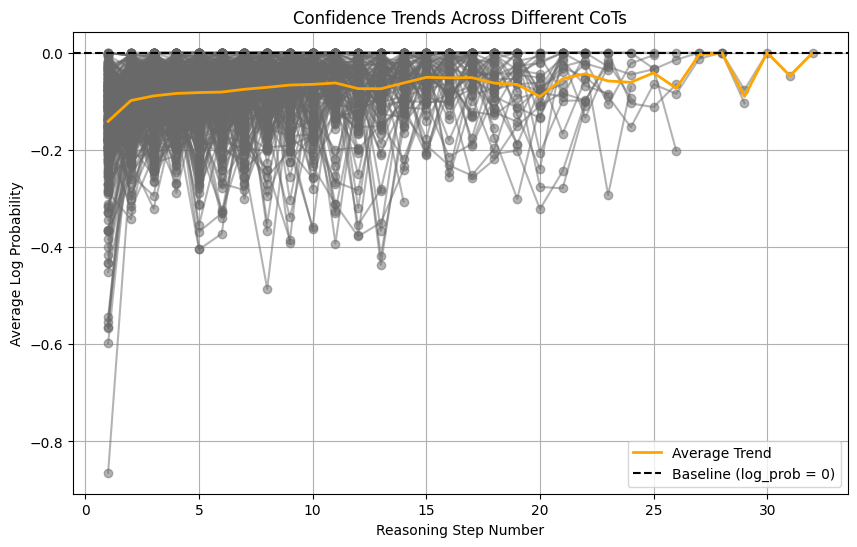

In [ ]:
def plot_multiple_confidence_trends(df):
    plt.figure(figsize=(10, 6))  # Set figure size

    all_step_nums = []
    all_avg_log_probs = []

    for _, row in df.iterrows():
        conf_per_step = row["conf_per_step"]  # Extract step confidence data

        # Extract step numbers and log probabilities
        step_nums = [entry["step_num"] for entry in conf_per_step]
        avg_log_probs = [entry["avg_log_prob"] for entry in conf_per_step]

        # Convert to NumPy array to handle NaN values
        step_nums = np.array(step_nums)
        avg_log_probs = np.array(avg_log_probs)

        # Mask NaN values to prevent breaks in the plot
        valid_mask = ~np.isnan(avg_log_probs)
        plt.plot(step_nums[valid_mask], avg_log_probs[valid_mask],
                 marker="o", linestyle="-", color="dimgray", alpha=0.5)  # Darker gray

        # Store data for trend line
        all_step_nums.extend(step_nums[valid_mask])
        all_avg_log_probs.extend(avg_log_probs[valid_mask])

    # Compute trend line (average confidence per step)
    if all_step_nums:
        unique_steps = sorted(set(all_step_nums))  # Get unique step numbers
        avg_trend = [np.mean([all_avg_log_probs[i] for i in range(len(all_step_nums)) if all_step_nums[i] == step])
                     for step in unique_steps]

        # Plot overall trend line in orange
        plt.plot(unique_steps, avg_trend, color="orange", linestyle="-", linewidth=2, label="Average Trend")

    plt.xlabel("Reasoning Step Number")
    plt.ylabel("Average Log Probability")
    plt.title("Confidence Trends Across Different CoTs")
    plt.axhline(y=0, color="black", linestyle="--", label="Baseline (log_prob = 0)")

    plt.legend()
    plt.grid(True)
    plt.show()

# Call function with dataframe
plot_multiple_confidence_trends(df_gsm8k_att)



### Classification of confidence trends- K Means

In [ ]:
!pip install tslearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

# Extract valid sequences while handling NaNs
valid_indices = []
valid_sequences = []

for idx, seq in enumerate(df_gsm8k_att["conf_per_step"]):
    log_probs = np.array([step["avg_log_prob"] for step in seq if not np.isnan(step["avg_log_prob"])])
    if len(log_probs) > 0:  # Keep only non-empty sequences
        valid_sequences.append(log_probs)
        valid_indices.append(idx)

# Check if we have valid sequences
if not valid_sequences:
    print("No valid sequences found. Skipping clustering.")
else:
    # Normalize sequence lengths by padding to max length
    max_len = max(len(seq) for seq in valid_sequences)
    sequences_padded = np.array([
        np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=np.nan)
        for seq in valid_sequences
    ])

    # Normalize using mean variance scaling
    scaler = TimeSeriesScalerMeanVariance()
    X_dtw = scaler.fit_transform(sequences_padded)

    # Apply DTW K-Means Clustering
    n_clusters = 6  # Adjust as needed
    dtw_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True, random_state=42)
    cluster_labels = dtw_km.fit_predict(X_dtw)

    # Store results in the original DataFrame
    df_gsm8k_att["dtw_cluster"] = np.nan  # Initialize with NaN
    df_gsm8k_att.loc[valid_indices, "dtw_cluster"] = cluster_labels

    cluster_representative_cots = {}

    for cluster in sorted(df_gsm8k_att["dtw_cluster"].dropna().unique()):  # Get unique clusters
      # Get all indices of rows belonging to this cluster
      cluster_indices = df_gsm8k_att[df_gsm8k_att["dtw_cluster"] == cluster].index.tolist()

      # Pick up to three representative CoTs (if available)
      representative_indices = cluster_indices[:3]  # Take the first three
      cluster_representative_cots[cluster] = df_gsm8k_att.loc[representative_indices, "cot_generated"].tolist()

    # Print or save the representative CoTs
    for cluster, cots in cluster_representative_cots.items():
      print(f"Cluster {cluster}:")
      for i, cot in enumerate(cots, 1):
        print(f"  Example {i}: {cot}\n")

# Display dataframe with assigned clusters
print(df_gsm8k_att[["conf_per_step", "dtw_cluster", "cot_generated"]])


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks 

8.700 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    2.0s


5.492 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s


5.164 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s


5.078 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s


5.026 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s


4.983 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s


4.964 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s


4.942 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s


4.928 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s


4.922 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s


4.918 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s


4.918 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s


4.918 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s


4.918 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s


Cluster 0.0:
  Example 1: ['James runs 3 sprints each week, and each sprint is 60 meters.', 'To find the total meters he runs in a week, I multiply the number of sprints by the distance per sprint.', 'So, 3 sprints multiplied by 60 meters per sprint equals 180 meters.', 'Therefore, James runs a total of 180 meters each week.']

  Example 2: ['Kylar is purchasing 16 glasses for his new apartment.', 'The first glass costs $5, and every subsequent glass costs 60% of $5, which is $3.', 'Kylar wants to buy 16 glasses, so we need to calculate the total cost for all of them.', "First, let's determine how many groups of two glasses Kylar can buy.", 'Dividing 16 by 2 gives 8 groups.', 'Each group consists of two glasses: one costing $5 and the other costing $3.', 'The cost for each group is $5 + $3 = $8.', 'Now, multiplying the cost per group by the number of groups: $8 * 8 = $64.', 'Therefore, Kylar needs to pay $64 for all 16 glasses.']

  Example 3: ['John starts at home and drives away at 6

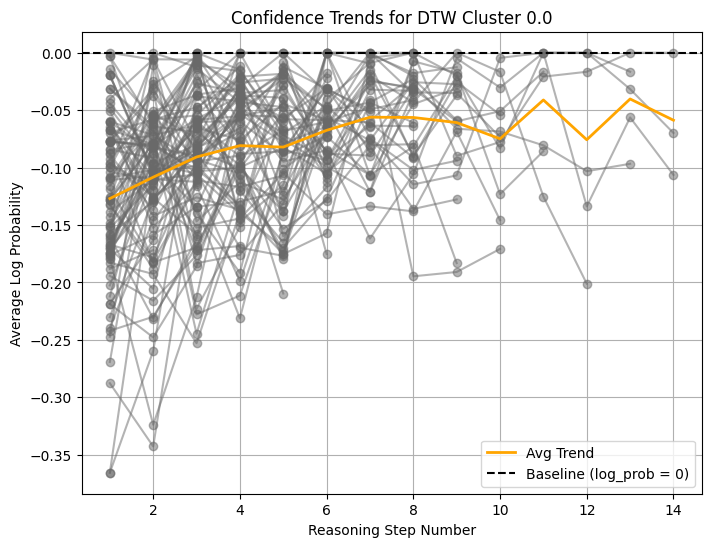


=== Representative CoTs for Cluster 0.0 ===

Example 1:
['James runs 3 sprints each week, and each sprint is 60 meters.', 'To find the total meters he runs in a week, I multiply the number of sprints by the distance per sprint.', 'So, 3 sprints multiplied by 60 meters per sprint equals 180 meters.', 'Therefore, James runs a total of 180 meters each week.']

Example 2:
['Kylar is purchasing 16 glasses for his new apartment.', 'The first glass costs $5, and every subsequent glass costs 60% of $5, which is $3.', 'Kylar wants to buy 16 glasses, so we need to calculate the total cost for all of them.', "First, let's determine how many groups of two glasses Kylar can buy.", 'Dividing 16 by 2 gives 8 groups.', 'Each group consists of two glasses: one costing $5 and the other costing $3.', 'The cost for each group is $5 + $3 = $8.', 'Now, multiplying the cost per group by the number of groups: $8 * 8 = $64.', 'Therefore, Kylar needs to pay $64 for all 16 glasses.']

Example 3:
['John starts a

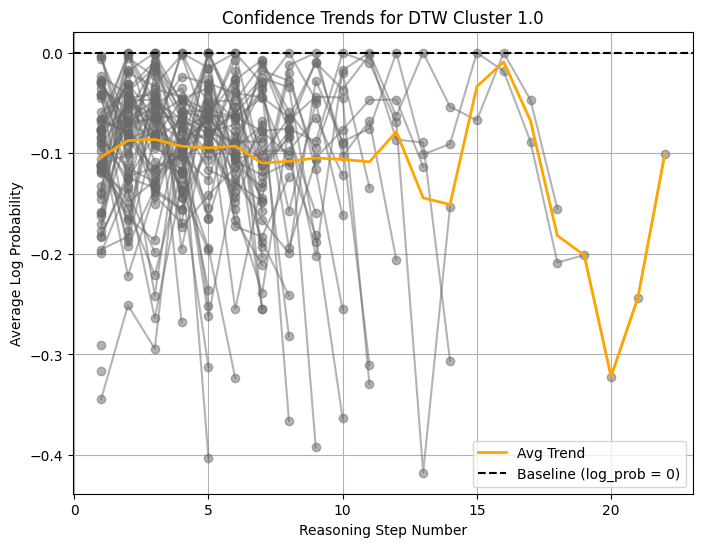


=== Representative CoTs for Cluster 1.0 ===

Example 1:
['The robe takes 2 bolts of blue fiber and half that much white fiber.', 'Half of 2 is 1.', 'So, the total number of bolts is 2 plus 1, which equals 3.', 'Answer: 3']

Example 2:
['Josh bought a house for $80,000.', 'He spent an additional $50,000 on repairs, bringing the total cost to $130,000.', 'The repairs increased the value of the house by 150%, which means the value went up by $65,000 (150% of $50,000).', 'The new value of the house is $195,000.', 'Josh sold the house for $210,000.', 'His profit is the selling price minus the total cost, which is $210,000 - $130,000 = $80,000.', 'Therefore, Josh made an $80,000 profit.']

Example 3:
['Carla is downloading a 200 GB file.', 'Normally she can download 2 GB/minute, but 40% of the way through the download, Windows forces a restart to install updates, which takes 20 minutes.', 'Then Carla has to restart the download from the beginning.', 'To find the load, we need to determine t

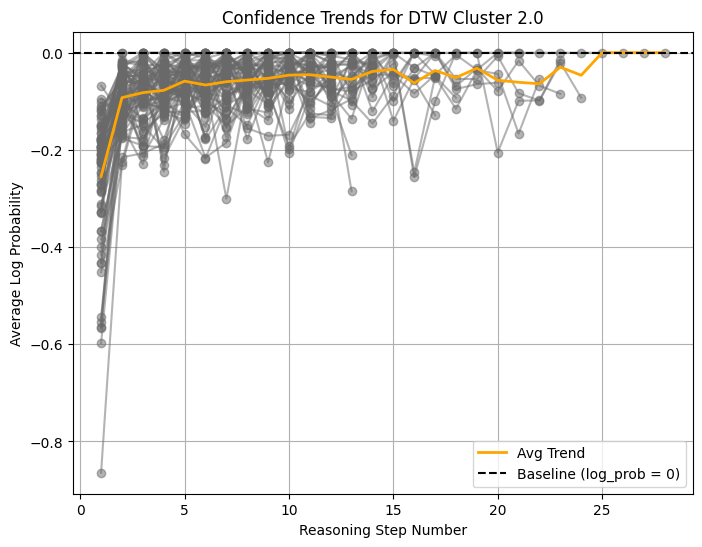


=== Representative CoTs for Cluster 2.0 ===

Example 1:
["Let's break down the problem step by step.", 'First, we know that Seattle has 20 sheep.', 'Next, Charleston has 4 times as many sheep as Seattle, so we can calculate the number of sheep Charleston has by multiplying 20 by 4.', '20 multiplied by 4 equals 80.', 'So, Charleston has 80 sheep.', 'Now, Toulouse has twice as many sheep as Charleston.', 'Since Charleston has 80 sheep, Toulouse must have twice that amount.', '2 multiplied by 80 equals 160.', 'Therefore, Toulouse has 160 sheep.', 'To find the total number of sheep all three locations have together, we add up the sheep from Toulouse, Charleston, and Seattle.', '160 plus 80 is 240, and then adding 20 gives us a total of 260.', 'So, together, Toulouse, Charleston, and Seattle have 260 sheep.', 'The final answer is 260.']

Example 2:
['First, determine the number of downloads in each month.', 'In the first month, the program had 60 downloads.', 'In the second month, the down

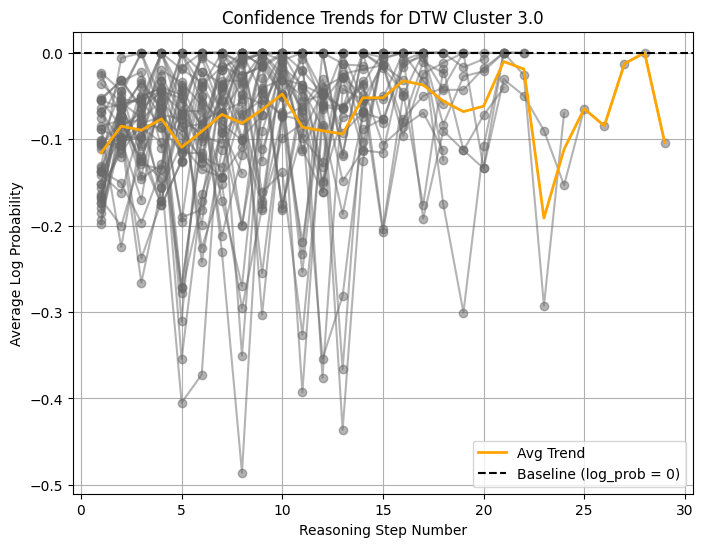


=== Representative CoTs for Cluster 3.0 ===

Example 1:
['The merchant is looking to maximize his profit by choosing between two purchase plans: jewelry worth $5,000 and electronic gadgets worth $8,000.', 'The financial advisor predicts that the jewelry market will rise by 2.5%, while the electronic gadgets market will rise by 1.2%.', 'To determine the optimal choice, I first need to calculate the expected value of each purchase plan after the market fluctuations.', 'For the jewelry plan, the expected value is $5,000 multiplied by (1 + 0.025), which equals $5,125.', 'Similarly, for the electronic gadgets plan, the expected value is $8,000 multiplied by (1 + 0.012), resulting in $8,096.', 'By comparing these two expected values, the merchant can identify which purchase plan offers a higher expected profit.', 'The expected profit for the jewelry plan is $5,125 - $5,000 = $125, while the expected profit for the electronic gadgets plan is $8,096 - $8,000 = $96.', 'Since the jewelry plan o

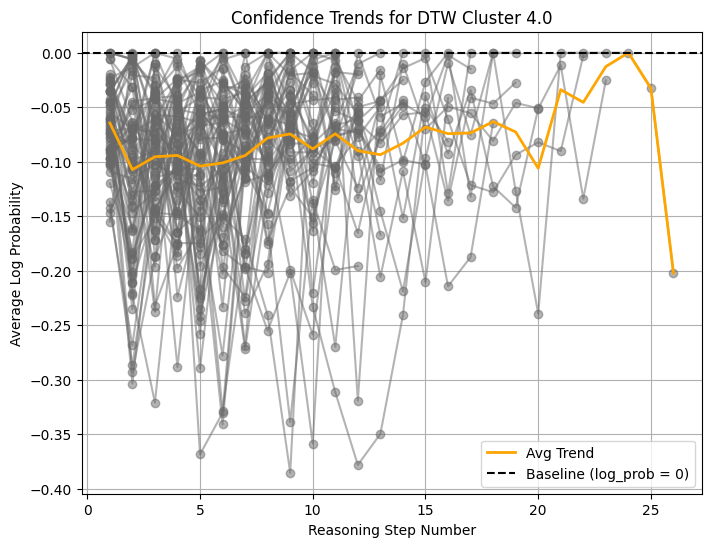


=== Representative CoTs for Cluster 4.0 ===

Example 1:
['Wendi feeds her flock of 20 chickens with mixed feed containing seeds, mealworms, and vegetables.', 'Each chicken consumes three cups of feed daily.', 'She distributes the feed into three separate meals throughout the day.', 'In the morning, she provides 15 cups of feed to her flock.', 'In the afternoon, she gives them another 25 cups.', 'To determine how many cups are needed for the final meal, we first calculate the total feed consumed per day.', 'Since there are 20 chickens, each requiring three cups, the total daily feed required is 20 multiplied by 3, which equals 60 cups.', 'Wendi has already given out 15 cups in the morning and 25 cups in the afternoon, totaling 40 cups.', 'Subtracting this from the daily requirement, 60 minus 40, equals 20 cups.', 'Therefore, Wendi needs to provide 20 cups of feed in the final meal of the day.']

Example 2:
['Jill earns $20 per hour teaching and $30 per hour as a cheerleading coach.', '

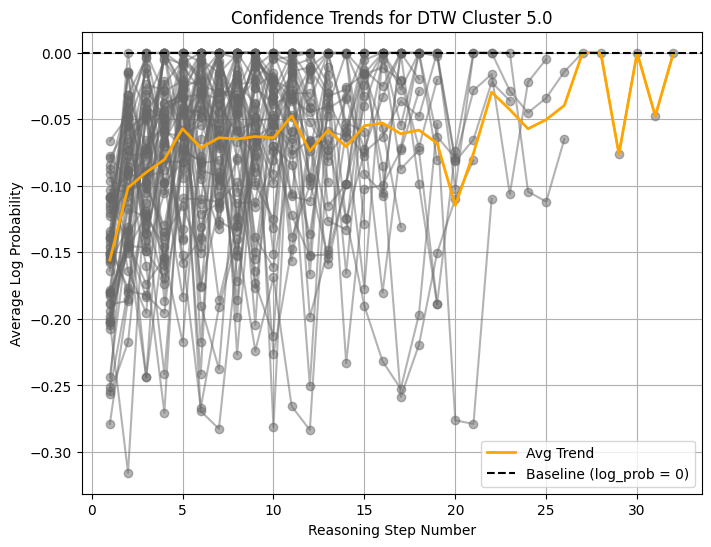


=== Representative CoTs for Cluster 5.0 ===

Example 1:
['Janet has 16 eggs per day.', 'She uses 3 for breakfast and 4 for muffins, totaling 7 eggs.', 'This leaves 16 - 7 = 9 eggs.', 'She sells each egg for $2, so her daily earnings are 9 * $2 = $18.', 'Answer: $18']

Example 2:
['Carlos needs to determine when he will start earning money on his lemon tree.', "First, let's calculate the initial cost of planting the tree, which is $90.", 'Each year, the tree will grow 7 lemons, which he can sell for $1.5 each.', 'Therefore, the revenue from selling the lemons each year is 7 * 1.5 = $10.50.', 'Next, we need to account for the costs.', 'It costs $3 a year to water and feed the tree.', 'Therefore, the net profit each year is 10.50 - 3 = $7.50.', 'To determine how many years it will take for Carlos to start earning money, we need to find when the total revenue from selling the lemons exceeds the initial planting cost.', 'The initial cost is $90, and the net profit per year is $7.50.', 'The

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cluster_confidence_trends(df, cluster_representative_cots):
    unique_clusters = sorted(df["dtw_cluster"].dropna().unique())  # Get unique cluster IDs

    for cluster in unique_clusters:
        plt.figure(figsize=(8, 6))  # Separate figure for each cluster

        # Subset data for the cluster
        cluster_df = df[df["dtw_cluster"] == cluster]

        all_step_nums = []
        all_avg_log_probs = []

        for _, row in cluster_df.iterrows():
            conf_per_step = row["conf_per_step"]  # Extract confidence steps

            # Extract step numbers and log probabilities
            step_nums = [entry["step_num"] for entry in conf_per_step]
            avg_log_probs = [entry["avg_log_prob"] for entry in conf_per_step]

            # Convert to NumPy array to handle NaNs
            step_nums = np.array(step_nums)
            avg_log_probs = np.array(avg_log_probs)

            # Mask NaN values
            valid_mask = ~np.isnan(avg_log_probs)
            plt.plot(step_nums[valid_mask], avg_log_probs[valid_mask],
                     marker="o", linestyle="-", color="dimgray", alpha=0.5)  # Dark grey lines

            # Store for trend line
            all_step_nums.extend(step_nums[valid_mask])
            all_avg_log_probs.extend(avg_log_probs[valid_mask])

        # Compute trend line (average log probability per step in cluster)
        if all_step_nums:
            unique_steps = sorted(set(all_step_nums))  # Get unique step numbers
            avg_trend = [np.mean([all_avg_log_probs[i] for i in range(len(all_step_nums)) if all_step_nums[i] == step])
                         for step in unique_steps]

            # Plot overall trend line in orange
            plt.plot(unique_steps, avg_trend, color="orange", linestyle="-", linewidth=2, label="Avg Trend")

        plt.xlabel("Reasoning Step Number")
        plt.ylabel("Average Log Probability")
        plt.title(f"Confidence Trends for DTW Cluster {cluster}")
        plt.axhline(y=0, color="black", linestyle="--", label="Baseline (log_prob = 0)")
        plt.legend()
        plt.grid(True)

        # Show plot
        plt.show()

        # Display the three representative CoTs for this cluster
        print(f"\n=== Representative CoTs for Cluster {cluster} ===\n")
        representative_cots = cluster_representative_cots.get(cluster, [])

        if representative_cots:
            for i, cot in enumerate(representative_cots, 1):
                print(f"Example {i}:\n{cot}\n")
        else:
            print("No representative CoTs found.")

        print("\n" + "=" * 80 + "\n")

# Call function with clustering results
plot_cluster_confidence_trends(df_gsm8k_att, cluster_representative_cots)





### Classification of confidence trends- With HDB Scan

In [ ]:
!pip install tslearn hdbscan

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw  # DTW distance computation

# Sample Data (Replace with df_gsm8k_att["conf_per_step"])
df = pd.DataFrame({
    "conf_per_step": [
        [{'step_num': 0, 'avg_log_prob': -0.22}, {'step_num': 1, 'avg_log_prob': -0.16}, {'step_num': 2, 'avg_log_prob': -0.1}],
        [{'step_num': 0, 'avg_log_prob': -0.5}, {'step_num': 1, 'avg_log_prob': -0.3}, {'step_num': 2, 'avg_log_prob': -0.1}],
        [{'step_num': 0, 'avg_log_prob': -0.2}, {'step_num': 1, 'avg_log_prob': -0.25}, {'step_num': 2, 'avg_log_prob': -0.5}],
        [{'step_num': 0, 'avg_log_prob': -0.1}, {'step_num': 1, 'avg_log_prob': -0.05}, {'step_num': 2, 'avg_log_prob': -0.02}],
        [{'step_num': 0, 'avg_log_prob': -0.3}, {'step_num': 1, 'avg_log_prob': -0.28}, {'step_num': 2, 'avg_log_prob': -0.1}],
        [{'step_num': 0, 'avg_log_prob': -0.56}, {'step_num': 1, 'avg_log_prob': -0.1}, {'step_num': 2, 'avg_log_prob': -0.45},{'step_num': 3, 'avg_log_prob': -0.05}],
        [{'step_num': 0, 'avg_log_prob': -0.75}, {'step_num': 1, 'avg_log_prob': -0.5}, {'step_num': 2, 'avg_log_prob': -0.25},{'step_num': 3, 'avg_log_prob': -0.05}]
    ]
})

# Extract log probability sequences & handle NaNs
sequences = [
    np.array([step["avg_log_prob"] for step in seq if not np.isnan(step["avg_log_prob"])])
    for seq in df["conf_per_step"]
]

# Normalize sequence lengths by padding to max length
max_len = max(len(seq) for seq in sequences)
sequences_padded = np.array([
    np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=np.nan)
    for seq in sequences
])

# Normalize sequences using mean variance scaling
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(sequences_padded)

# Compute DTW distance matrix
dtw_distance_matrix = cdist_dtw(X_scaled)

# Apply HDBSCAN clustering (metric="precomputed" since we use a DTW distance matrix)
hdb = hdbscan.HDBSCAN(min_cluster_size=2, metric="precomputed")
df["hdbscan_cluster"] = hdb.fit_predict(dtw_distance_matrix)

# Print cluster assignments
print(df[["conf_per_step", "hdbscan_cluster"]])


                                       conf_per_step  hdbscan_cluster
0  [{'step_num': 0, 'avg_log_prob': -0.22}, {'ste...               -1
1  [{'step_num': 0, 'avg_log_prob': -0.5}, {'step...               -1
2  [{'step_num': 0, 'avg_log_prob': -0.2}, {'step...               -1
3  [{'step_num': 0, 'avg_log_prob': -0.1}, {'step...               -1
4  [{'step_num': 0, 'avg_log_prob': -0.3}, {'step...               -1
5  [{'step_num': 0, 'avg_log_prob': -0.56}, {'ste...               -1
6  [{'step_num': 0, 'avg_log_prob': -0.75}, {'ste...               -1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
num_clusters = df["hdbscan_cluster"].nunique()
print(f"Number of clusters found: {num_clusters}")

Number of clusters found: 1


## 3.2 Analysing attention patterns

### Computing backtracking ratios

In [ ]:
def compute_stepwise_backtracking_ratio(attentions, gen_tok, tokenizer, inputs, k=2):
    """
    Compute the average backtracking ratio for each reasoning step and overall average.

    Parameters:
    - attentions: Tensor of shape (num_layers, num_heads, seq_len, seq_len)
    - gen_tokens: Tensor of generated token IDs (batch_size, seq_len)
    - tokenizer: Tokenizer to decode tokens
    - k: Number of reasoning steps back to consider as "far past"

    Returns:
    - avg_ratios_per_step: List of average backtracking ratios per step.
    - overall_avg_ratio: Overall average backtracking ratio across all steps.
    """

    # num_layers, num_heads, seq_len, _ = attentions[0].shape
    num_layers = len(attentions[0])
    num_heads = attentions[0][0].shape[1]
    # seq_len = len(attentions)
    avg_ratios_per_step = {}

    # Decode generated tokens to identify reasoning steps
    gen_start = inputs["input_ids"].shape[1]
    gen_tokens = gen_tok[:, gen_start:]  # Generated tokens only
    gen_text_tokens = [tokenizer.decode([tok]) for tok in gen_tokens[0]]
    step_markers = [".", "?", "!"]
    step_indices = [0]

    # Identify step boundaries
    for i, token in enumerate(gen_text_tokens):
        if token.endswith(tuple(step_markers)):
            step_indices.append(i + 1)

    # print(len(attentions))
    count =0

    # Iterate over steps
    if len(step_indices)-1 < 3:
      avg_ratios_per_step= None
      overall_avg_ratio = None

    else:
      for i in range(len(step_indices) - 1):
        count +=1
        # print("Count :",count)
        start, end = step_indices[i], step_indices[i + 1]
        if start >= end:
          continue

        step_attention_ratios = []  # Store ratios for all tokens in the step
        # print(gen_text_tokens[start:end])

        for to in range(start, end):
            token_ratios = []  # Store backtracking ratio for all layers/heads at token t
            temp = attentions[to]


            for layer in range(num_layers):
                attention = temp[layer]
                for head in range(num_heads):
                    attn_matrix = attention[0,head]  # Shape (seq_len, seq_len)

                    # Sum of attention to all past tokens
                    past_attention = attn_matrix[0, :to].sum()

                    if i>1:
                      # Sum of attention to the first 25% of tokens in the series
                      far_past_start = step_indices[max(0, i // 4)]
                      far_past_attention = attn_matrix[0,:far_past_start].sum()

                      # Compute ratio (avoid division by zero)
                      ratio = (far_past_attention / past_attention).item() if past_attention > 0 else 0
                      token_ratios.append(ratio)

            # Average ratio across all layers and heads for this token
            step_attention_ratios.append(t.tensor(token_ratios, dtype=t.float32).mean().item())

        # Average across all tokens in the step
        avg_ratios_per_step[i]=t.tensor(step_attention_ratios).mean().item()

    return avg_ratios_per_step

In [ ]:
# File paths in Google Drive
csv_path_atts = "/content/drive/MyDrive/AI Assignment/MATS- Neel Nanda/Spring 2025/CoT Store/GSM8K/cot_rerun_results.xlsx"

# Check if CSV file exists
if os.path.exists(csv_path_atts):
    print("File already exists. Loading previous results...")

    df_gsm8k_atts = pd.read_excel(csv_path_atts)
    print(df_gsm8k_atts.head())  # Show first few rows

else:
    print("No existing file found. Running CoT reasoning...")
    df_gsm8k_atts,acc = run_cot_with_att(gsm8k_ds_test,csv_path_atts,num_runs=1,total=10,with_logits=False,with_att=True)

File already exists. Loading previous results...
   run_id  sample_id                                           question  \
0       1          1  Janet’s ducks lay 16 eggs per day. She eats th...   
1       1          2  A robe takes 2 bolts of blue fiber and half th...   
2       1          3  Josh decides to try flipping a house.  He buys...   
3       1          4  James decides to run 3 sprints 3 times a week....   
4       1          5  Every day, Wendi feeds each of her chickens th...   

                                     answer_response  \
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...   
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...   
2  The cost of the house and repairs came out to ...   
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...   
4  If each chicken eats 3 cups of feed per day, t...   

                                       cot_generated  ground_truth  \
0  ['Janet has 16 eggs per day.', 'She uses 3 for...            18   
1  ['The robe takes 2 b

In [ ]:
df_gsm8k_atts = df_gsm8k_atts[df_gsm8k_atts["run_id"] < 5]

In [ ]:
df_gsm8k_atts["bratio_per_step"].dropna

<bound method Series.dropna of 0      {0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.64469671...
1      {0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.81044906...
2      {0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.65101361...
3                               {0: nan, 1: nan, 2: 0.0}
4      {0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.83186280...
                             ...                        
395    {0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.76575052...
396    {0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.77339631...
397                     {0: nan, 1: nan, 2: 0.0, 3: 0.0}
398                     {0: nan, 1: nan, 2: 0.0, 3: 0.0}
399                     {0: nan, 1: nan, 2: 0.0, 3: 0.0}
Name: bratio_per_step, Length: 400, dtype: object>

In [ ]:
df_gsm8k_atts["bratio_per_step"]

,bratio_per_step
0,"{0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.64469671..."
1,"{0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.81044906..."
2,"{0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.65101361..."
3,"{0: nan, 1: nan, 2: 0.0}"
4,"{0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.83186280..."
...,...
395,"{0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.76575052..."
396,"{0: nan, 1: nan, 2: 0.0, 3: 0.0, 4: 0.77339631..."
397,"{0: nan, 1: nan, 2: 0.0, 3: 0.0}"
398,"{0: nan, 1: nan, 2: 0.0, 3: 0.0}"


In [ ]:
def parse_bratio_per_step(value):
    if not isinstance(value, str) or value.lower() == "nan":
        return []  # Ignore NaNs

    # Extract key-value pairs (numbers before and after ':')
    matches = re.findall(r"(\d+):\s*([\d\.\-e]+)", value)  # Supports float & scientific notation

    parsed_values = [(int(k), float(v)) for k, v in matches if v.lower() != "nan"]

    return parsed_values  # Returns list of tuples [(x1, y1), (x2, y2), ...]

# Apply parsing function
df_gsm8k_atts["bratio_per_step_parsed"] = df_gsm8k_atts["bratio_per_step"].apply(parse_bratio_per_step)

# Print first 10 parsed values
print(df_gsm8k_atts["bratio_per_step_parsed"].head(10).tolist())


[[(2, 0.0), (3, 0.0), (4, 0.6446967124938965), (5, 0.772005021572113), (6, 0.655214250087738), (7, 0.6878392696380615), (8, 0.5428323149681091), (9, 0.6471681594848633), (10, 0.5720675587654114), (11, 0.4784339964389801), (12, 0.41158467531204224)], [(2, 0.0), (3, 0.0), (4, 0.8104490637779236)], [(2, 0.0), (3, 0.0), (4, 0.6510136127471924), (5, 0.5857442617416382), (6, 0.4621700644493103)], [(2, 0.0)], [(2, 0.0), (3, 0.0), (4, 0.8318628072738647), (5, 0.7957016229629517), (6, 0.7374367713928223), (7, 0.661137044429779), (8, 0.6653590798377991), (9, 0.5222104787826538), (10, 0.472283273935318), (11, 0.4679625332355499), (12, 0.49840646982192993)], [(2, 0.0), (3, 0.0), (4, 0.769916296005249), (5, 0.7740955352783203), (6, 0.6901965141296387), (7, 0.6479331851005554), (8, 0.4813430607318878), (9, 0.5274890661239624)], [(2, 0.0), (3, 0.0), (4, 0.783451497554779), (5, 0.772847592830658), (6, 0.7685902118682861), (7, 0.7019608616828918), (8, 0.6002013683319092), (9, 0.5448213815689087), (10, 

### Plotting backtracking ratios for all CoTs

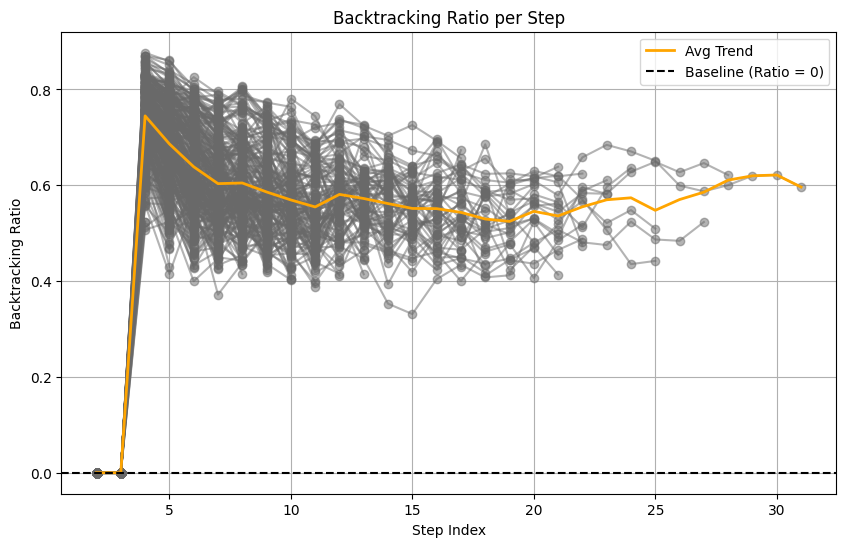

In [ ]:
def plot_backtracking_ratio(df):
    plt.figure(figsize=(10, 6))

    all_step_nums = []
    all_ratios = []

    for _, row in df.iterrows():
        parsed_values = row["bratio_per_step_parsed"]

        if parsed_values:  # Skip empty rows
            x_values, y_values = zip(*parsed_values)  # Unzip into X and Y

            # Convert to NumPy array to handle NaNs
            x_values = np.array(x_values)
            y_values = np.array(y_values)

            # Mask NaN values
            valid_mask = ~np.isnan(y_values)
            plt.plot(x_values[valid_mask], y_values[valid_mask],
                     marker='o', linestyle='-', color="dimgray", alpha=0.5)  # Dark grey lines

            # Store values for average trend calculation
            all_step_nums.extend(x_values[valid_mask])
            all_ratios.extend(y_values[valid_mask])

    # Compute trend line (average backtracking ratio per step)
    if all_step_nums:
        unique_steps = sorted(set(all_step_nums))  # Get unique step numbers
        avg_trend = [np.mean([all_ratios[i] for i in range(len(all_step_nums)) if all_step_nums[i] == step])
                     for step in unique_steps]

        # Plot overall trend line in orange
        plt.plot(unique_steps, avg_trend, color="orange", linestyle="-", linewidth=2, label="Avg Trend")

    # Labels and title
    plt.xlabel("Step Index")
    plt.ylabel("Backtracking Ratio")
    plt.title("Backtracking Ratio per Step")
    plt.axhline(y=0, color="black", linestyle="--", label="Baseline (Ratio = 0)")
    plt.legend()
    plt.grid(True)

    plt.show()

# Call the function
plot_backtracking_ratio(df_gsm8k_atts)



### Classification of backtracking rations - K means

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


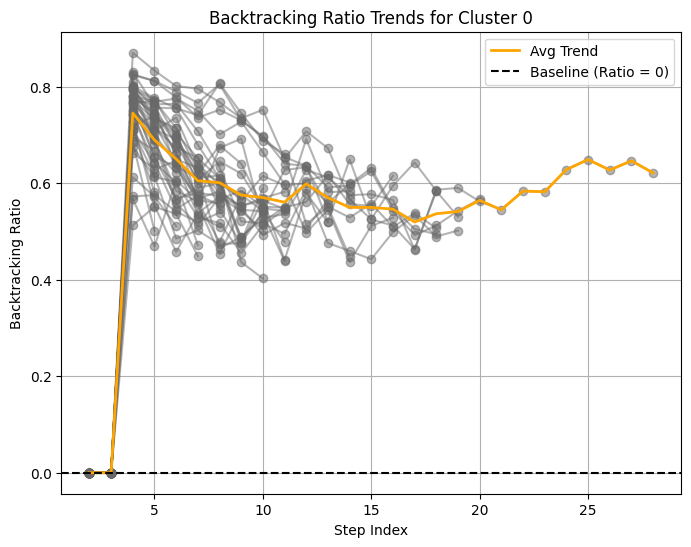


=== Typical CoTs for Cluster 0 ===

Example 1:
['The robe takes 2 bolts of blue fiber and half that much white fiber.', 'Half of 2 is 1.', 'So, the total number of bolts is 2 plus 1, which equals 3.', 'Answer: 3']

Example 2:
['James runs 3 sprints each week, and each sprint is 60 meters.', 'To find the total meters he runs in a week, I multiply the number of sprints by the distance per sprint.', 'So, 3 sprints multiplied by 60 meters per sprint equals 180 meters.', 'Therefore, James runs a total of 180 meters each week.']

Example 3:
['The candle melts by 2 centimeters every hour it burns.', 'It burns from 1:00 PM to 5:00 PM, which is a total of 4 hours.', '2 centimeters multiplied by 4 hours equals 8 centimeters.', 'Therefore, the candle will be 8 centimeters shorter after burning from 1:00 PM to 5:00 PM.']




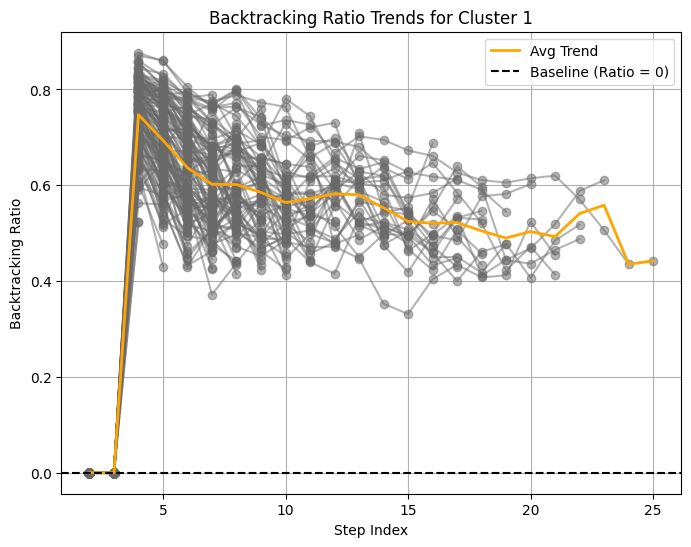


=== Typical CoTs for Cluster 1 ===

Example 1:
['Josh bought a house for $80,000.', 'He spent an additional $50,000 on repairs, bringing the total cost to $130,000.', 'The repairs increased the value of the house by 150%, which means the value went up by $65,000 (150% of $50,000).', 'The new value of the house is $195,000.', 'Josh sold the house for $210,000.', 'His profit is the selling price minus the total cost, which is $210,000 - $130,000 = $80,000.', 'Therefore, Josh made an $80,000 profit.']

Example 2:
['Kylar is purchasing 16 glasses for his new apartment.', 'The first glass costs $5, and every subsequent glass costs 60% of $5, which is $3.', 'Kylar wants to buy 16 glasses, so we need to calculate the total cost for all of them.', "First, let's determine how many groups of two glasses Kylar can buy.", 'Dividing 16 by 2 gives 8 groups.', 'Each group consists of two glasses: one costing $5 and the other costing $3.', 'The cost for each group is $5 + $3 = $8.', 'Now, multiplying

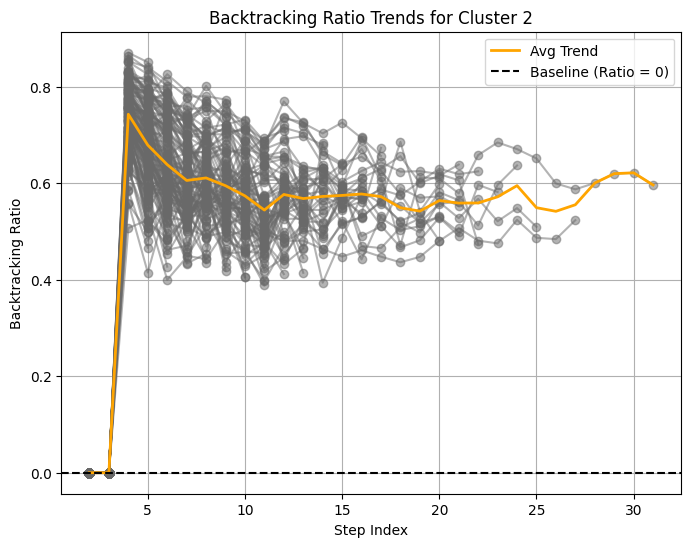


=== Typical CoTs for Cluster 2 ===

Example 1:
['Janet has 16 eggs per day.', 'She uses 3 for breakfast and 4 for muffins, totaling 7 eggs.', 'This leaves 16 - 7 = 9 eggs.', 'She sells each egg for $2, so her daily earnings are 9 * $2 = $18.', 'Answer: $18']

Example 2:
['Wendi feeds her flock of 20 chickens with mixed feed containing seeds, mealworms, and vegetables.', 'Each chicken consumes three cups of feed daily.', 'She distributes the feed into three separate meals throughout the day.', 'In the morning, she provides 15 cups of feed to her flock.', 'In the afternoon, she gives them another 25 cups.', 'To determine how many cups are needed for the final meal, we first calculate the total feed consumed per day.', 'Since there are 20 chickens, each requiring three cups, the total daily feed required is 20 multiplied by 3, which equals 60 cups.', 'Wendi has already given out 15 cups in the morning and 25 cups in the afternoon, totaling 40 cups.', 'Subtracting this from the daily requ

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

def perform_kmeans_clustering(df, n_clusters=3):
    # Extract sequences of backtracking ratios
    sequences = [
        np.array([step[1] for step in row["bratio_per_step_parsed"]])
        for _, row in df.iterrows() if row["bratio_per_step_parsed"]
    ]

    # Normalize sequence lengths by padding to max length
    max_len = max(len(seq) for seq in sequences)
    sequences_padded = np.array([
        np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=np.nan)
        for seq in sequences
    ])

    # Normalize sequences
    scaler = TimeSeriesScalerMeanVariance()
    X_scaled = scaler.fit_transform(sequences_padded)

    # Apply K-Means clustering (using DTW as the metric)
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Assign cluster labels to DataFrame
    df["kmeans_cluster"] = np.nan  # Initialize with NaN
    df.loc[df.index[:len(cluster_labels)], "kmeans_cluster"] = cluster_labels

    return df, cluster_labels

def get_representative_cots(df, n_clusters=3):
    cluster_representative_cots = {}

    for cluster in range(n_clusters):
        cluster_df = df[df["kmeans_cluster"] == cluster]
        if not cluster_df.empty:
            # Select 3 representative CoTs from the cluster
            cluster_representative_cots[cluster] = cluster_df["cot_generated"].head(3).tolist()

    return cluster_representative_cots

def plot_cluster_trends(df, cluster_representative_cots, n_clusters=3):
    for cluster in range(n_clusters):
        plt.figure(figsize=(8, 6))

        # Subset data for the cluster
        cluster_df = df[df["kmeans_cluster"] == cluster]

        all_step_nums = []
        all_ratios = []

        for _, row in cluster_df.iterrows():
            parsed_values = row["bratio_per_step_parsed"]

            if parsed_values:
                x_values, y_values = zip(*parsed_values)

                # Convert to NumPy array to handle NaNs
                x_values = np.array(x_values)
                y_values = np.array(y_values)

                # Mask NaN values
                valid_mask = ~np.isnan(y_values)
                plt.plot(x_values[valid_mask], y_values[valid_mask],
                         marker='o', linestyle='-', color="dimgray", alpha=0.5)

                # Store for trend line
                all_step_nums.extend(x_values[valid_mask])
                all_ratios.extend(y_values[valid_mask])

        # Compute and plot the average trend line
        if all_step_nums:
            unique_steps = sorted(set(all_step_nums))
            avg_trend = [np.mean([all_ratios[i] for i in range(len(all_step_nums)) if all_step_nums[i] == step])
                         for step in unique_steps]
            plt.plot(unique_steps, avg_trend, color="orange", linestyle="-", linewidth=2, label="Avg Trend")

        plt.xlabel("Step Index")
        plt.ylabel("Backtracking Ratio")
        plt.title(f"Backtracking Ratio Trends for Cluster {cluster}")
        plt.axhline(y=0, color="black", linestyle="--", label="Baseline (Ratio = 0)")
        plt.legend()
        plt.grid(True)

        # Show plot
        plt.show()

        # Print 3 representative CoTs for this cluster
        print(f"\n=== Typical CoTs for Cluster {cluster} ===\n")
        for i, cot in enumerate(cluster_representative_cots.get(cluster, [])):
            print(f"Example {i+1}:\n{cot}\n")
        print("=" * 50 + "\n")

# Perform clustering and save cluster labels
df_gsm8k_atts, cluster_labels = perform_kmeans_clustering(df_gsm8k_atts, n_clusters=3)

# Get 3 representative CoTs per cluster
cluster_representative_cots = get_representative_cots(df_gsm8k_atts, n_clusters=3)

# Plot trends for each cluster with representative CoTs
plot_cluster_trends(df_gsm8k_atts, cluster_representative_cots, n_clusters=3)


#4. Reasoning steering

## Generated synthetic math dataset

In [ ]:
import random
import math
import pandas as pd

def generate_math_dataset(num_examples=100):
    dataset = []
    operations = ["+", "-", "*", "/", "**", "sqrt", "lcm", "gcd", "!"]

    for _ in range(num_examples):
        op = random.choice(operations)

        # Generate numbers based on operation
        if op in ["+", "-", "*", "/"]:
            a, b = random.randint(10, 99), random.randint(10, 99)
            if op == "/":
                b = random.randint(1, 10)

        elif op == "**":
            a = random.randint(2, 9)
            b = random.randint(2, 4)

        elif op == "sqrt":
            a = random.randint(4, 100)
            a = a * a  # Ensure perfect squares
            b = None

        elif op in ["lcm", "gcd"]:
            a, b = random.randint(10, 50), random.randint(10, 50)

        elif op == "!":
            a = random.randint(3, 7)
            b = None

        # Compute correct result
        if op == "+":
            correct_answer = a + b
        elif op == "-":
            correct_answer = a - b
        elif op == "*":
            correct_answer = a * b
        elif op == "/":
            correct_answer = round(a / b, 2)
        elif op == "**":
            correct_answer = a ** b
        elif op == "sqrt":
            correct_answer = int(math.sqrt(a))
        elif op == "lcm":
            correct_answer = math.lcm(a, b)
        elif op == "gcd":
            correct_answer = math.gcd(a, b)
        elif op == "!":
            correct_answer = math.factorial(a)

        # 50% chance of wrong answer
        is_wrong = random.choice([True, False])

        if is_wrong:
            # Generate a confident wrong answer
            if isinstance(correct_answer, int):
                wrong_answer = correct_answer + random.choice([-3, -2, -1, 1, 2, 3])
            else:
                wrong_answer = round(correct_answer + random.choice([-0.5, -0.3, 0.3, 0.5]), 2)
        else:
            wrong_answer = correct_answer  # No mistake

        # Format the question text
        if op in ["+", "-", "*", "/"]:
            input_text = f"What is {a} {op} {b}?"
        elif op == "**":
            input_text = f"What is {a} raised to the power of {b}?"
        elif op == "sqrt":
            input_text = f"What is the square root of {a}?"
        elif op == "lcm":
            input_text = f"What is the least common multiple of {a} and {b}?"
        elif op == "gcd":
            input_text = f"What is the greatest common divisor of {a} and {b}?"
        elif op == "!":
            input_text = f"What is {a} factorial?"

        # Generate first try response (forward calculation)
        if op in ["+", "-", "*", "/"]:
            negative_output = f"So, {a}{op}{b} = {wrong_answer}."
        elif op == "**":
            negative_output = f"So, {a}^({b}) = {wrong_answer}."
        elif op == "sqrt":
            negative_output = f"So, sqrt({a}) = {wrong_answer}."
        elif op == "lcm":
            negative_output = f"So, LCM({a}, {b}) = {wrong_answer}."
        elif op == "gcd":
            negative_output = f"So, GCD({a}, {b}) = {wrong_answer}."
        elif op == "!":
            negative_output = f"So, {a}! = {wrong_answer}."

        # Generate rechecking step (inverse calculation)
        if is_wrong:
            if op == "+":
                recheck_output = f"{negative_output} Let me check again... {b} + {a} = {correct_answer}."
            elif op == "-":
              if not(is_wrong):
                recheck_output = f"{negative_output} Let me check again... {wrong_answer} + {b} = {a}."
              else:
                recheck_output = f"{negative_output} Let me check again... {wrong_answer} + {b} = {wrong_answer+b} which is not equal to {a}. Hence the first computation was wrong. Computing again {a} + {b} = {correct_answer}"
            elif op == "*":
                recheck_output = f"{negative_output} Let me check again... {b} * {a} = {correct_answer}."
            elif op == "/":
              if not(is_wrong):
                recheck_output = f"{negative_output} Let me check again... {correct_answer} * {b} = {a}."
              else:
                recheck_output = f"{negative_output} Let me check again... {wrong_answer} * {b} = {b*wrong_answer} which is not equal to {a}. Hence the first computation was wrong. Computing again {a} / {b} = {correct_answer}"
            elif op == "**":
              if not(is_wrong):
                recheck_output = f"{negative_output} Let me check again... The {b}th root of {correct_answer} is {a}."
              else:
                recheck_output = f"{negative_output} Let me check again... The {b}th root of {wrong_answer} is {wrong_answer ** (1/b)} which is not equal to{a}. Hence the first computation was wrong. Computing again {a} ** {b} = {correct_answer}"
            elif op == "sqrt":
              if not(is_wrong):
                recheck_output = f"{negative_output} Let me check again... {correct_answer}^2 = {a}."
              else:
                recheck_output = f"{negative_output} Let me check again... {wrong_answer}^2 = {wrong_answer^2} which is not equal to {a}. Hence the first computation was wrong. Computing again sqrt({a}) = {correct_answer}"
            elif op == "lcm":
                recheck_output = f"{negative_output} Let me check again... The smallest multiple of both {a} and {b} is {correct_answer}."
            elif op == "gcd":
                recheck_output = f"{negative_output} Let me check again... The largest number that divides both {a} and {b} is {correct_answer}."
            elif op == "!":
                recheck_output = f"{negative_output} Let me check again... {a-1}! * {a} = {correct_answer}."
        else:
            recheck_output = negative_output  # No need to recheck if already correct

        # Store in dataset
        dataset.append((input_text, recheck_output, negative_output))

    return dataset

def save_math_dataset(csv_path, num_examples=100):
    dataset = generate_math_dataset(num_examples)
    df = pd.DataFrame(dataset, columns=["Question", "Positive Response", "Negative Response"])
    print(df.head)
    df.to_csv(csv_path, index=False)
    print(f"Dataset saved at: {csv_path}")

# Example usage
csv_path = "/content/drive/MyDrive/AI Assignment/MATS- Neel Nanda/Spring 2025/CoT Store/Math_Dset.csv"
save_math_dataset(csv_path, num_examples=100)


<bound method NDFrame.head of                                              Question  \
0                 What is 2 raised to the power of 3?   
1                                    What is 40 - 92?   
2                                     What is 35 / 7?   
3                                     What is 37 / 3?   
4                    What is the square root of 2916?   
..                                                ...   
95                                   What is 59 * 90?   
96                                   What is 46 - 45?   
97                                   What is 23 + 92?   
98  What is the greatest common divisor of 26 and 45?   
99                What is 2 raised to the power of 4?   

                                    Positive Response      Negative Response  
0   So, 2^(3) = 10. Let me check again... The 3th ...        So, 2^(3) = 10.  
1                                    So, 40-92 = -52.       So, 40-92 = -52.  
2   So, 35/7 = 5.5. Let me check again... 5.5 * 

## Compute steering vector

In [ ]:
def get_per_token_activations(text, model, tokenizer):
    """
    Extracts per-token activations for all layers.

    Returns:
    - Dictionary where keys are layer indices and values are (seq_len, hidden_dim) numpy arrays.
    """
    inputs = tokenizer(text, return_tensors="pt").to(model.device)

    with t.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Extract hidden states for all layers
    all_layer_hidden_states = outputs.hidden_states  # Tuple of (num_layers + 1, batch_size, seq_len, hidden_dim)

    # Convert to dictionary with layers as keys
    activations = {
        layer_idx: layer_states.squeeze(0).cpu().numpy()  # Shape: (seq_len, hidden_dim)
        for layer_idx, layer_states in enumerate(all_layer_hidden_states)
    }

    return activations  # Dict[layer] -> (seq_len, hidden_dim)

In [ ]:
import numpy as np

def compute_steering_vector(dataset, model, tokenizer):
    """Computes the steering vector using activations from all layers and identifies the most affected layer."""

    num_layers = model.config.num_hidden_layers + 1  # +1 to include input embeddings
    layer_norm_changes = np.zeros(num_layers)  # Track activation change per layer

    # Store steering vectors and activations
    steering_vectors = {layer: [] for layer in range(num_layers)}
    activations_per_layer = {layer: {"wrong": [], "self_check": [], "corrected": []} for layer in range(num_layers)}

    for question, recheck_response, wrong_response in tqdm(dataset):
        # Get per-token activations for both responses
        wrong_acts = get_per_token_activations(wrong_response, model, tokenizer)
        recheck_acts = get_per_token_activations(recheck_response, model, tokenizer)

        # Tokenize to find key tokens for activation extraction
        wrong_tokens = tokenizer.tokenize(wrong_response)
        recheck_tokens = tokenizer.tokenize(recheck_response)

        # Identify token positions (last token of each stage)
        idx_wrong = len(wrong_tokens) - 2  # Last token before the period
        idx_self_check = recheck_tokens.index("Let") if "Let" in recheck_tokens else idx_wrong
        idx_corrected = len(recheck_tokens) - 2  # Last token before final period

        # Compute steering vectors per layer
        for layer in range(num_layers):
            act_wrong = wrong_acts[layer][idx_wrong]  # Activation at wrong answer
            act_self_check = recheck_acts[layer][idx_self_check]  # Activation at self-verification step
            act_corrected = recheck_acts[layer][idx_corrected]  # Activation at corrected answer

            # Store raw activations for later analysis
            activations_per_layer[layer]["wrong"].append(act_wrong)
            activations_per_layer[layer]["self_check"].append(act_self_check)
            activations_per_layer[layer]["corrected"].append(act_corrected)

            # Compute different steering vectors
            direct_correction_vector = act_corrected - act_wrong
            uncertainty_vector = act_self_check - act_wrong

            # Store steering vectors
            steering_vectors[layer].append((direct_correction_vector, uncertainty_vector))

            # Compute magnitude of change (Euclidean norm)
            norm_change = np.linalg.norm(direct_correction_vector) + np.linalg.norm(uncertainty_vector)
            layer_norm_changes[layer] += norm_change

    # Compute final mean steering vectors per layer
    final_steering_vectors = {}
    for layer in range(num_layers):
        direct_vectors = np.array([vec[0] for vec in steering_vectors[layer]])
        uncertainty_vectors = np.array([vec[1] for vec in steering_vectors[layer]])

        final_steering_vectors[layer] = {
            "direct": np.mean(direct_vectors, axis=0),
            "uncertainty": np.mean(uncertainty_vectors, axis=0),
        }

    # Find layer with maximum change
    max_layer = np.argmax(layer_norm_changes)

    return final_steering_vectors, max_layer, activations_per_layer


In [ ]:
# Load dataset
csv_path_mdset = "/content/drive/MyDrive/Articles /Math_Dset.xlsx"
dataset_df = pd.read_excel(csv_path_mdset, engine="openpyxl")
dataset = dataset_df.values.tolist()  # Convert to list of (Question, Positive Response, Negative Response)

In [ ]:
model.to(device)
final_steering_vectors, max_layer, activations_per_layer = compute_steering_vector(dataset, model, tokenizer)


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting toolkit

def plot_pca_variance_per_layer_3d(activations_per_layer, n_components=3):
    """
    Performs PCA on activation differences across layers and plots a 3D scatter plot
    distinguishing wrong, self-check, and corrected responses for each layer.

    Parameters:
    - activations_per_layer: Dictionary {layer: {wrong: Tensor, self_check: Tensor, corrected: Tensor}}
    - n_components: Number of PCA components (default=3)

    Returns:
    - None (displays separate 3D scatter plots per layer)
    """
    num_layers = len(activations_per_layer)

    for layer in range(num_layers):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')  # 3D subplot

        # Extract activations for each stage
        layer_acts = activations_per_layer[layer]
        wrong_acts = np.array(layer_acts["wrong"])
        self_check_acts = np.array(layer_acts["self_check"])
        corrected_acts = np.array(layer_acts["corrected"])

        # Flatten if needed
        wrong_acts = wrong_acts.reshape(wrong_acts.shape[0], -1)
        self_check_acts = self_check_acts.reshape(self_check_acts.shape[0], -1)
        corrected_acts = corrected_acts.reshape(corrected_acts.shape[0], -1)

        print(f"Layer {layer}: Wrong Variance - {np.var(wrong_acts, axis=0).sum()}")

        # Perform PCA with normalization
        pca = PCA(n_components=n_components)
        scaler = StandardScaler()
        all_acts = scaler.fit_transform(np.vstack([wrong_acts, self_check_acts, corrected_acts]))  # Normalize activations
        reduced_acts = pca.fit_transform(all_acts)
        print(f"Layer {layer}: PCA Explained Variance Ratio - {pca.explained_variance_ratio_}")

        # Split transformed activations back
        split_1 = wrong_acts.shape[0]
        split_2 = split_1 + self_check_acts.shape[0]
        wrong_points = reduced_acts[:split_1]
        self_check_points = reduced_acts[split_1:split_2]
        corrected_points = reduced_acts[split_2:]

        # 3D Scatter plot
        ax.scatter(wrong_points[:, 0], wrong_points[:, 1], wrong_points[:, 2], color='blue', label="Wrong", alpha=0.7)
        ax.scatter(self_check_points[:, 0], self_check_points[:, 1], self_check_points[:, 2], color='orange', label="Self-Check", alpha=0.7)
        ax.scatter(corrected_points[:, 0], corrected_points[:, 1], corrected_points[:, 2], color='red', label="Corrected", alpha=0.7)

        # Labels & formatting
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        ax.set_title(f"PCA 3D Scatter Plot - Layer {layer}")
        ax.legend()
        ax.grid(True)

        plt.show()

# Example usage:
# plot_pca_variance_per_layer_3d(activations_per_layer, n_components=3)


In [ ]:
np.save('/content/drive/MyDrive/Articles /final_steering_vectors.npy', final_steering_vectors)

## Applying steering

In [ ]:
def generate_cot_with_steering(model, tokenizer, question, steering_vectors, layer_to_modify, alpha):
    """
    Generates CoT reasoning and applies activation steering **only when '=' is detected**.

    Returns:
    - str: Generated output with activation steering applied.
    """
    cot_prompt = (
        f"A conversation between User and Assistant. The user asks a question, and the Assistant solves it.",
        f"The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.",
        f"The reasoning process and answer are enclosed within <think> </think> and ",
        f"<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think> ",
        f"<answer> answer here </answer>.",
        f" The final answer must be a numeric or a decimal. ",
        f"User: {question}. Assistant: "
    )

    cot_prompt = " ".join(cot_prompt)

    input_ids = tokenizer.encode(cot_prompt, return_tensors="pt").to(model.device)
    generated_ids = []
    steering_triggered = False

    def hook_fn(module, input, output):
        if steering_triggered:
            return output + alpha * steering_vectors[layer_to_modify]  # Apply steering vector
        return output  # No modification before '=' appears

    handle = model.model.layers[layer_to_modify].mlp.register_forward_hook(hook_fn)

    with torch.no_grad():
        while True:
            outputs = model(input_ids)
            logits = outputs.logits[:, -1, :]
            next_token_id = torch.argmax(logits, dim=-1).item()
            generated_ids.append(next_token_id)

            if tokenizer.decode([next_token_id]) == "=":
                steering_triggered = True  # Activate steering after "="

            if next_token_id == tokenizer.eos_token_id or len(generated_ids) > 512:
                break

            input_ids = torch.cat([input_ids, torch.tensor([[next_token_id]]).to(model.device)], dim=-1)

    handle.remove()
    return tokenizer.decode(generated_ids)



In [ ]:
def generate_cot_answer(model, tokenizer, question, max_tokens=512):
    """
    Generates a step-by-step Chain-of-Thought (CoT) reasoning response for a given question.

    Args:
    - model: Language model.
    - tokenizer: Tokenizer for the model.
    - question (str): The input question.
    - max_tokens (int): Maximum number of tokens to generate.

    Returns:
    - str: The generated CoT response.
    """
    cot_prompt = (
        f"A conversation between User and Assistant. The user asks a question, and the Assistant solves it.",
        f"The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.",
        f"The reasoning process and answer are enclosed within <think> </think> and ",
        f"<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think> ",
        f"<answer> answer here </answer>.",
        f" The final answer must be a numeric or a decimal. ",
        f"User: {question}. Assistant: "
    )

    cot_prompt = " ".join(cot_prompt)

    input_ids = tokenizer.encode(cot_prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(input_ids, max_length=max_tokens, pad_token_id=tokenizer.eos_token_id)

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


In [ ]:
def run_cot_with_activation_steering(
    dset: list,
    csv_path: str,
    model,
    tokenizer,
    steering_vectors,
    layer_to_modify: int,
    alpha: float,
    num_runs: int,
    total: int
):
    """
    Runs step-by-step reasoning with and without activation steering.

    Args:
    - dset (list): Dataset containing questions and answers.
    - csv_path (str): Path to save the results as a CSV.
    - model: Language model.
    - tokenizer: Tokenizer for the model.
    - steering_vectors (dict): Precomputed steering vectors per layer.
    - layer_to_modify (int): Layer where activation steering is applied.
    - alpha (float): Strength of steering intervention.
    - num_runs (int): Number of runs to repeat.
    - total (int): Number of problems to evaluate.

    Returns:
    - df (DataFrame): Final results dataframe.
    - accuracies (list): Accuracy per run.
    """
    correct_counts_no_steering = [0] * num_runs
    correct_counts_steering = [0] * num_runs
    results = []

    write_headers = not os.path.exists(csv_path)

    for k in range(num_runs):
        run_results = []

        for i in tqdm(range(total), desc=f"Run {k+1}/{num_runs}"):
            question = dset[i]["question"]
            true_answer = extract_number(dset[i]["answer"])

            # Generate normal CoT (without activation steering)
            original_output = generate_cot_answer(model, tokenizer, question)

            # Apply activation steering **only when '=' appears**
            steered_output = generate_cot_with_steering(
                model, tokenizer, question, steering_vectors, layer_to_modify, alpha
            )

            # Extract numerical answers
            original_answer = extract_number(original_output)
            steered_answer = extract_number(steered_output)

            # Check correctness
            is_correct_no_steering = (true_answer == original_answer)
            is_correct_steering = (true_answer == steered_answer)

            if is_correct_no_steering:
                correct_counts_no_steering[k] += 1
            if is_correct_steering:
                correct_counts_steering[k] += 1

            # Store results
            run_results.append({
                "run_id": k + 1,
                "sample_id": i + 1,
                "question": question,
                "answer_response": dset[i]["answer"],
                "ground_truth": true_answer,
                "cot_response_no_steering": original_output,
                "cot_response_steering": steered_output,
                "is_correct_no_steering": is_correct_no_steering,
                "is_correct_steering": is_correct_steering
            })

            # Save incrementally after every iteration
            df = pd.DataFrame(run_results)
            df.to_csv(csv_path, mode="a", header=write_headers, index=False)
            write_headers = False  # Ensure headers are written only once

        results.append(run_results)

    # Compute and print accuracy per run
    accuracies_no_steering = [correct / total for correct in correct_counts_no_steering]
    accuracies_steering = [correct / total for correct in correct_counts_steering]

    for k in range(num_runs):
        print(f"Run {k+1} Accuracy (No Steering): {accuracies_no_steering[k]:.2%}")
        print(f"Run {k+1} Accuracy (With Steering): {accuracies_steering[k]:.2%}")

    return pd.DataFrame(results), accuracies_no_steering, accuracies_steering


In [ ]:
# File paths in Google Drive
csv_path_3 = "/content/drive/MyDrive/Articles /with_steer.csv"

# Check if JSON file exists
if os.path.exists(csv_path_3):
    print("File already exists. Loading previous results...")
    df_gsm8k = pd.read_csv(csv_path_3)

    print(df_gsm8k.head())  # Show first few rows

else:
    print("No existing file found. Running CoT reasoning...")
    df_gsm8k = run_cot_with_activation_steering(gsm8k_ds_test, csv_path_3, model, tokenizer, final_steering_vectors, layer_to_modify=27, alpha=10, num_runs=1, total=5)



No existing file found. Running CoT reasoning...


Run 1/1:  80%|████████  | 4/5 [09:37<02:24, 144.34s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 396.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 396.12 MiB is free. Process 12227 has 14.35 GiB memory in use. Of the allocated memory 13.72 GiB is allocated by PyTorch, and 517.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Sample example- With partial steering- Token triggered

Attempted to execute this but ran into difficulties due to large inconcsistencies of output between model.generate() and model(). Additionally ths code is very slow for inferencing without the efficiencies of model.generate()

In [ ]:
import torch
# Load the steering vector
steering_vector = np.load("/content/drive/MyDrive/AI Assignment/MATS- Neel Nanda/Spring 2025/final_steering_vectors.npy", allow_pickle=True)
steering_vector = steering_vector.item()

print(type(steering_vector))  # Check if it's a dict or list
print(steering_vector)        # Print a portion of the data


<class 'dict'>
{0: {'direct': array([ 0.00535034, -0.00094879,  0.0067421 , ...,  0.00154114,
       -0.0016024 , -0.01172852], dtype=float32), 'uncertainty': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 1: {'direct': array([ 0.03123123,  0.00704343, -0.05078568, ...,  0.02095484,
        0.00225831,  0.00997038], dtype=float32), 'uncertainty': array([ 6.5341590e-07,  3.3720397e-07, -3.7573278e-07, ...,
       -1.4517457e-07, -3.9488079e-08, -8.6925922e-07], dtype=float32)}, 2: {'direct': array([ 0.07693534, -0.00288725, -0.07928747, ..., -0.01924687,
       -0.01550549,  0.0375946 ], dtype=float32), 'uncertainty': array([ 7.1719290e-07, -2.1129847e-07, -2.1815300e-07, ...,
       -2.7630477e-07,  1.4998018e-07, -1.2644381e-06], dtype=float32)}, 3: {'direct': array([ 0.06233745,  0.1548598 ,  0.00439617, ..., -0.00772768,
       -0.03299163,  0.24850768], dtype=float32), 'uncertainty': array([ 1.6115605e-07, -2.0775944e-07,  3.2441690e-07, ...,
        4.3742358e-07, -1.169554

In [ ]:
selected_key = 28  # Change this to select a different vector
steering_vector = steering_vector[selected_key]["uncertainty"]

# Ensure it's a float32 array
steering_vector = torch.tensor(steering_vector, dtype=torch.float32, device=device).to(device)

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm  # Import tqdm for progress tracking

def generate_reasoning_output(prompt, alpha, apply_steering=False,max_tokens=200,num_steer=5):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    generated_tokens = []  # Store generated token IDs

    if apply_steering:
            # Ensure steering vector is on CUDA and properly reshaped
            steering_vector_torch = torch.tensor(
                steering_vector, dtype=torch.float32, device=device
            ).view(1, 1, -1)

    current_input = inputs["input_ids"].to(device)  # Ensure input is on CUDA

    decoded = tokenizer.decode(current_input[0].tolist(), skip_special_tokens=True)
    print(decoded)

    with torch.no_grad():
      output = model.generate(
            input_ids=current_input,
            max_new_tokens=1,  # Generate only one token per step
            return_dict_in_generate=True,  # Get additional info like scores
            output_hidden_states=True  # Get hidden states if needed
            )

      current_input = output.sequences
      next_token = output.sequences[:, -1:]
      generated_tokens.append(next_token.item())

      print(type(output.sequences))
      print(output.sequences.shape)

      for _ in tqdm(range(max_tokens), desc="Generating Tokens", unit="token"):
            output = model.generate(
            input_ids=current_input,
            max_new_tokens=1,  # Generate only one token per step
            return_dict_in_generate=True,  # Get additional info like scores
            output_hidden_states=True  # Get hidden states if needed
            )

            # Extract the newly generated token
            next_token = output.sequences[:, -1:]  # Get only the new token

            # Append token to sequence
            generated_tokens.append(next_token.item())

            # Update current_input
            current_input = torch.cat([current_input, next_token], dim=1)

            # decoded_text = tokenizer.decode(current_input[0].tolist(), skip_special_tokens=True)
            # print(decoded_text)

            # Decode only the last 5 tokens
            decoded_last_five_tokens = tokenizer.decode(generated_tokens[-(num_steer):], skip_special_tokens=True)

            # Check for punctuation only in the last 5 tokens
            punctuation_flag = any(p in decoded_last_five_tokens for p in ".!?")

            if apply_steering and punctuation_flag:  # Apply steering at punctuation
                print("Applied steer")
                # Get last layer's hidden states (shape: batch_size x seq_len x hidden_dim)
                print("Otput.hidden_states: ",len(output.hidden_states[-1]))
                hidden_states = output.hidden_states[-1]

                # Get the last layer's hidden states
                last_layer_hidden_states = hidden_states[-1]  # Last layer in the tuple

                # Extract the last token's hidden state (index -1 for last token)
                last_token_hidden_state = last_layer_hidden_states[:, -1, :].to(device)
                print("Last_token_hidden_state_size: ", last_token_hidden_state.shape)

                # Apply steering
                steered_hidden_states = last_token_hidden_state + alpha * steering_vector_torch

                full_embeds = model.get_input_embeddings()(current_input).clone()
                full_embeds[:, -1, :] = steered_hidden_states.clone()

                new_outputs = model(
                                inputs_embeds=full_embeds,
                                attention_mask = torch.ones_like(current_input, device=device)  # Ensure padding tokens are ignored
                                    )

                logits = new_outputs.logits[:, -1, :]  # Get updated logits

                # **Choose new token from steered logits**
                next_token = torch.argmax(logits, dim=-1, keepdim=True)

                # Append steered token to sequence
                generated_tokens[-1] = next_token.item()

                current_input[:, -1] = next_token  # Replace last token with next_token

              # Append instead of overwrite
            # print(current_input.shape)

            # Stop if EOS token is reached
            if next_token.item() == tokenizer.eos_token_id:
                break

    return tokenizer.decode(generated_tokens, skip_special_tokens=True)


In [ ]:

print(f"do_sample: {getattr(model.config, 'do_sample', 'Not set')}")
print(f"temperature: {getattr(model.config, 'temperature', 'Not set')}")
print(f"top_k: {getattr(model.config, 'top_k', 'Not set')}")
print(f"top_p: {getattr(model.config, 'top_p', 'Not set')}")


do_sample: False
temperature: 1.0
top_k: 50
top_p: 1.0


In [ ]:
# Example multi-step reasoning prompt
prompt = "Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make? Solve step by step, giving final answer as a numeric"
baseline_output = generate_reasoning_output(prompt, alpha =0, apply_steering=False,max_tokens=50)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make? Solve step by step, giving final answer as a numeric
<class 'torch.Tensor'>
torch.Size([1, 70])


Generating Tokens:   0%|          | 0/50 [00:00<?, ?token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 1/50 [00:00<00:05,  9.48token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   6%|▌         | 3/50 [00:00<00:04, 10.24token/s]The attention mask and the pad token id were not

In [ ]:
# Generate outputs
steered_output_1 = generate_reasoning_output(prompt, alpha = 0, apply_steering=True,max_tokens=50)

<ipython-input-246-c6ed34bd9522>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector_torch = torch.tensor(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make? Solve step by step, giving final answer as a numeric
<class 'torch.Tensor'>
torch.Size([1, 70])


Generating Tokens:   0%|          | 0/50 [00:00<?, ?token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 1/50 [00:00<00:10,  4.72token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer
Otput.hidden_states:  29
Last_token_hidden_state_size:  torch.Size([1, 1536])


Generating Tokens:   4%|▍         | 2/50 [00:00<00:09,  4.93token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer
Otput.hidden_states:  29
Last_token_hidden_state_size:  torch.Size([1, 1536])
Applied steer
Otput.hidden_states:  29
Last_token_hidden_state_size:  torch.Size([1, 1536])


Generating Tokens:   6%|▌         | 3/50 [00:00<00:09,  5.00token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   8%|▊         | 4/50 [00:00<00:09,  5.01token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer
Otput.hidden_states:  29
Last_token_hidden_state_size:  torch.Size([1, 1536])
Applied steer
Otput.hidden_states:  29
Last_token_hidden_state_size:  torch.Size([1, 1536])


Generating Tokens:  10%|█         | 5/50 [00:01<00:09,  4.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  12%|█▏        | 6/50 [00:01<00:08,  4.93token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer
Otput.hidden_states:  29
Last_token_hidden_state_size:  torch.Size([1, 1536])


Generating Tokens:  14%|█▍        | 7/50 [00:01<00:08,  4.94token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer
Otput.hidden_states:  29
Last_token_hidden_state_size:  torch.Size([1, 1536])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  18%|█▊        | 9/50 [00:01<00:06,  6.57token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  22%|██▏       | 11/50 [00:01<00:05,  7.66token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior

Applied steer
Otput.hidden_states:  29
Last_token_hidden_state_size:  torch.Size([1, 1536])


Generating Tokens:  36%|███▌      | 18/50 [00:02<00:03,  8.10token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  38%|███▊      | 19/50 [00:02<00:04,  6.93token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer
Otput.hidden_states:  29
Last_token_hidden_state_size:  torch.Size([1, 1536])


Generating Tokens:  40%|████      | 20/50 [00:02<00:03,  7.52token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  44%|████▍     | 22/50 [00:03<00:03,  8.44token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  46%|████▌     | 23/50 [00:03<00:03,  8.74token/s]The attention mask and the pad token 

In [ ]:
steered_output_2 = generate_reasoning_output(prompt, alpha = 0.01, apply_steering=True,max_tokens=350)

<ipython-input-155-745b2c70563f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector_torch = torch.tensor(


Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make? Solve step by step, giving final answer as a numeric


Generating Tokens:   0%|          | 0/350 [00:00<?, ?token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   0%|          | 1/350 [00:00<00:52,  6.59token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 2/350 [00:00<00:48,  7.15token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 3/350 [00

Applied steer


Generating Tokens:   2%|▏         | 6/350 [00:00<00:58,  5.89token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   2%|▏         | 7/350 [00:01<01:02,  5.47token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   2%|▏         | 8/350 [00:01<01:05,  5.21token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   3%|▎         | 9/350 [00:01<01:07,  5.09token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   3%|▎         | 10/350 [00:01<01:07,  5.01token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   3%|▎         | 11/350 [00:01<01:09,  4.89token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   3%|▎         | 12/350 [00:02<01:09,  4.84token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   4%|▎         | 13/350 [00:02<01:10,  4.79token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   4%|▍         | 14/350 [00:02<01:10,  4.74token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   4%|▍         | 15/350 [00:02<01:10,  4.74token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   5%|▍         | 16/350 [00:03<01:10,  4.70token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   5%|▍         | 17/350 [00:03<01:11,  4.68token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   5%|▌         | 18/350 [00:03<01:11,  4.64token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   5%|▌         | 19/350 [00:03<01:11,  4.63token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   6%|▌         | 20/350 [00:03<01:15,  4.40token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   6%|▌         | 21/350 [00:04<01:17,  4.25token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   6%|▋         | 22/350 [00:04<01:21,  4.04token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   7%|▋         | 23/350 [00:04<01:23,  3.92token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   7%|▋         | 24/350 [00:04<01:21,  4.00token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   7%|▋         | 25/350 [00:05<01:21,  4.00token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   7%|▋         | 26/350 [00:05<01:20,  4.05token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   8%|▊         | 27/350 [00:05<01:19,  4.04token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   8%|▊         | 28/350 [00:05<01:19,  4.06token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   8%|▊         | 29/350 [00:06<01:17,  4.13token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   9%|▊         | 30/350 [00:06<01:19,  4.01token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   9%|▉         | 31/350 [00:06<01:26,  3.71token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   9%|▉         | 32/350 [00:07<01:24,  3.77token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   9%|▉         | 33/350 [00:07<01:20,  3.95token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer
Applied steer


Generating Tokens:  10%|▉         | 34/350 [00:07<01:37,  3.24token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  10%|█         | 35/350 [00:08<02:02,  2.58token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  10%|█         | 36/350 [00:08<01:51,  2.81token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  11%|█         | 37/350 [00:08<01:39,  3.16token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  11%|█         | 38/350 [00:09<01:31,  3.43token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  11%|█         | 39/350 [00:09<01:25,  3.64token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  11%|█▏        | 40/350 [00:09<01:21,  3.82token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  12%|█▏        | 41/350 [00:09<01:17,  3.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  12%|█▏        | 42/350 [00:09<01:15,  4.09token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  12%|█▏        | 43/350 [00:10<01:13,  4.16token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  13%|█▎        | 44/350 [00:10<01:12,  4.21token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  13%|█▎        | 45/350 [00:10<01:11,  4.25token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  13%|█▎        | 46/350 [00:10<01:11,  4.26token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  13%|█▎        | 47/350 [00:11<01:11,  4.27token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  14%|█▎        | 48/350 [00:11<01:10,  4.26token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  14%|█▍        | 49/350 [00:11<01:10,  4.26token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  14%|█▍        | 50/350 [00:11<01:10,  4.23token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  15%|█▍        | 51/350 [00:12<01:10,  4.23token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  15%|█▍        | 52/350 [00:12<01:10,  4.20token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  15%|█▌        | 53/350 [00:12<01:10,  4.21token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  15%|█▌        | 54/350 [00:12<01:10,  4.20token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  16%|█▌        | 55/350 [00:12<01:10,  4.17token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  16%|█▌        | 56/350 [00:13<01:11,  4.13token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  16%|█▋        | 57/350 [00:13<01:10,  4.14token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  17%|█▋        | 58/350 [00:13<01:10,  4.15token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  17%|█▋        | 59/350 [00:13<01:10,  4.13token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  17%|█▋        | 60/350 [00:14<01:15,  3.85token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  17%|█▋        | 61/350 [00:14<01:23,  3.46token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  18%|█▊        | 62/350 [00:14<01:29,  3.21token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  18%|█▊        | 63/350 [00:15<01:33,  3.07token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  18%|█▊        | 64/350 [00:15<01:36,  2.97token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  19%|█▊        | 65/350 [00:16<01:36,  2.95token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  19%|█▉        | 66/350 [00:16<01:35,  2.97token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  19%|█▉        | 67/350 [00:16<01:35,  2.97token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  19%|█▉        | 68/350 [00:17<01:34,  2.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  20%|█▉        | 69/350 [00:17<01:34,  2.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  20%|██        | 70/350 [00:17<01:34,  2.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  20%|██        | 71/350 [00:18<01:33,  2.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  21%|██        | 72/350 [00:18<01:33,  2.96token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  21%|██        | 73/350 [00:18<01:33,  2.97token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  21%|██        | 74/350 [00:19<01:33,  2.95token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  21%|██▏       | 75/350 [00:19<01:33,  2.95token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  22%|██▏       | 76/350 [00:19<01:33,  2.93token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  22%|██▏       | 77/350 [00:20<01:33,  2.93token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  22%|██▏       | 78/350 [00:20<01:33,  2.92token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  23%|██▎       | 79/350 [00:20<01:33,  2.91token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  23%|██▎       | 80/350 [00:21<01:32,  2.91token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  23%|██▎       | 81/350 [00:21<01:32,  2.90token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  23%|██▎       | 82/350 [00:21<01:32,  2.88token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  24%|██▎       | 83/350 [00:22<01:32,  2.90token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  24%|██▍       | 84/350 [00:22<01:31,  2.89token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  24%|██▍       | 85/350 [00:22<01:31,  2.90token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  25%|██▍       | 86/350 [00:23<01:31,  2.88token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  25%|██▍       | 87/350 [00:23<01:31,  2.88token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  25%|██▌       | 88/350 [00:23<01:30,  2.88token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  25%|██▌       | 89/350 [00:24<01:30,  2.88token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  26%|██▌       | 90/350 [00:24<01:30,  2.87token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  26%|██▌       | 91/350 [00:24<01:30,  2.87token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  26%|██▋       | 92/350 [00:25<01:30,  2.86token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  27%|██▋       | 93/350 [00:25<01:30,  2.84token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  27%|██▋       | 94/350 [00:26<01:30,  2.81token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  27%|██▋       | 95/350 [00:26<01:30,  2.82token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  27%|██▋       | 96/350 [00:26<01:30,  2.80token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  28%|██▊       | 97/350 [00:27<01:30,  2.80token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  28%|██▊       | 98/350 [00:27<01:30,  2.79token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  28%|██▊       | 99/350 [00:27<01:30,  2.78token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  29%|██▊       | 100/350 [00:28<01:30,  2.77token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  29%|██▉       | 101/350 [00:28<01:29,  2.77token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  29%|██▉       | 102/350 [00:28<01:29,  2.76token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  29%|██▉       | 103/350 [00:29<01:29,  2.77token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  30%|██▉       | 104/350 [00:29<01:28,  2.77token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  30%|███       | 105/350 [00:30<01:28,  2.76token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  30%|███       | 106/350 [00:30<01:14,  3.26token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  31%|███       | 107/350 [00:30<01:04,  3.75token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  31%|███       | 108/350 [00:30<00:57,  4.18token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  31%|███    

Applied steer


Generating Tokens:  32%|███▏      | 112/350 [00:31<01:09,  3.44token/s]

Applied steer


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  32%|███▏      | 113/350 [00:31<01:14,  3.17token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  33%|███▎      | 114/350 [00:32<01:18,  3.00token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  33%|███▎      | 115/350 [00:32<01:21,  2.89token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  33%|███▎      | 116/350 [00:33<01:23,  2.81token/s]

Applied steer


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  33%|███▎      | 117/350 [00:33<01:24,  2.77token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  34%|███▎      | 118/350 [00:33<01:11,  3.26token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  34%|███▍      | 119/350 [00:33<01:02,  3.71token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  34%|███▍      | 120/350 [00:34<00:55,  4.13token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  35%|███▍   

Applied steer


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  35%|███▌      | 124/350 [00:34<00:53,  4.22token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  36%|███▌      | 125/350 [00:35<01:06,  3.38token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  36%|███▌      | 126/350 [00:35<01:00,  3.73token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  36%|███▋      | 127/350 [00:35<00:55,  3.99token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  37%|███▋   

Applied steer


Generating Tokens:  38%|███▊      | 133/350 [00:37<01:01,  3.52token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  38%|███▊      | 134/350 [00:37<01:11,  3.01token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  39%|███▊      | 135/350 [00:37<01:03,  3.37token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  39%|███▉      | 136/350 [00:38<00:58,  3.69token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  39%|███▉   

Applied steer


Generating Tokens:  45%|████▌     | 158/350 [00:43<00:56,  3.42token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  45%|████▌     | 159/350 [00:43<00:51,  3.70token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  46%|████▌     | 160/350 [00:43<00:48,  3.91token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  46%|████▌  

In [ ]:
steered_output_3 = generate_reasoning_output(prompt, alpha = 0.0001, apply_steering=True,max_tokens=350,num_steer=2)

<ipython-input-155-745b2c70563f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector_torch = torch.tensor(


Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make? Solve step by step, giving final answer as a numeric


Generating Tokens:   0%|          | 0/350 [00:00<?, ?token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   0%|          | 1/350 [00:00<00:58,  5.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 2/350 [00:00<01:27,  3.96token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   1%|          | 3/350 [00:00<01:29,  3.86token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   1%|          | 4/350 [00:00<01:09,  4.95token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|▏         | 5/350 [00:00<00:59,  5.79token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 6/350 [00:01<00:51,  6.64token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 7

Applied steer


Generating Tokens:   4%|▍         | 14/350 [00:02<01:00,  5.55token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   4%|▍         | 15/350 [00:02<00:52,  6.35token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   5%|▍         | 16/350 [00:02<00:47,  7.07token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   5%|▍         | 17/350 [00:02<00:43,  7.63token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   5%|▌         

Applied steer


Generating Tokens:   7%|▋         | 25/350 [00:03<00:53,  6.09token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   7%|▋         | 26/350 [00:03<00:47,  6.78token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   8%|▊         | 27/350 [00:03<00:54,  5.88token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   8%|▊         | 28/350 [00:04<00:48,  6.58token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   8%|▊         | 29/350 [00:04<00:44,  7.18token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   9%|▊         | 30/350 [00:04<00:41,  7.72token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   9%|▉         

Applied steer


Generating Tokens:  11%|█▏        | 40/350 [00:05<00:53,  5.77token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  12%|█▏        | 41/350 [00:05<00:48,  6.36token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  12%|█▏        | 42/350 [00:05<00:44,  6.90token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  12%|█▏        | 43/350 [00:06<00:41,  7.36token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  13%|█▎        

Applied steer


Generating Tokens:  15%|█▍        | 52/350 [00:07<00:54,  5.47token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  15%|█▌        | 53/350 [00:07<00:48,  6.13token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  15%|█▌        | 54/350 [00:07<00:44,  6.69token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  16%|█▌        | 55/350 [00:07<00:41,  7.12token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  16%|█▌        

Applied steer


Generating Tokens:  19%|█▉        | 68/350 [00:10<01:14,  3.78token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  20%|█▉        | 69/350 [00:10<01:05,  4.26token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  20%|██        | 70/350 [00:10<00:59,  4.69token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  20%|██        | 71/350 [00:10<00:57,  4.84token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  21%|██        

Applied steer


Generating Tokens:  23%|██▎       | 80/350 [00:12<01:09,  3.87token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  23%|██▎       | 81/350 [00:12<01:03,  4.27token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  23%|██▎       | 82/350 [00:12<00:58,  4.59token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  24%|██▎       | 83/350 [00:13<00:54,  4.87token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  24%|██▍       

Applied steer


Generating Tokens:  25%|██▍       | 86/350 [00:13<01:12,  3.63token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  25%|██▍       | 87/350 [00:14<01:04,  4.09token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  25%|██▌       | 88/350 [00:14<00:58,  4.49token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  25%|██▌       | 89/350 [00:14<00:54,  4.80token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  26%|██▌       

Applied steer


Generating Tokens:  29%|██▉       | 103/350 [00:17<01:06,  3.73token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  30%|██▉       | 104/350 [00:17<00:59,  4.14token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  30%|███       | 105/350 [00:17<00:54,  4.49token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  30%|███       | 106/350 [00:17<00:50,  4.79token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  31%|███    

Applied steer


Generating Tokens:  31%|███       | 109/350 [00:18<01:09,  3.48token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  31%|███▏      | 110/350 [00:18<01:01,  3.91token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  32%|███▏      | 111/350 [00:19<00:55,  4.32token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  32%|███▏      | 112/350 [00:19<00:50,  4.67token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  32%|███▏   

Applied steer


Generating Tokens:  35%|███▌      | 124/350 [00:21<00:56,  4.00token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  36%|███▌      | 125/350 [00:21<00:53,  4.19token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  36%|███▌      | 126/350 [00:22<00:52,  4.30token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  36%|███▋   

Applied steer


Generating Tokens:  39%|███▉      | 136/350 [00:24<01:00,  3.56token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  39%|███▉      | 137/350 [00:24<01:09,  3.06token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  39%|███▉      | 138/350 [00:25<01:02,  3.40token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  40%|███▉      | 139/350 [00:25<00:56,  3.71token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  40%|████   

Applied steer


Generating Tokens:  41%|████▏     | 145/350 [00:26<01:00,  3.41token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  42%|████▏     | 146/350 [00:27<01:10,  2.91token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  42%|████▏     | 147/350 [00:27<01:01,  3.29token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  42%|████▏     | 148/350 [00:27<00:56,  3.56token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  43%|████▎  

Applied steer


Generating Tokens:  45%|████▍     | 156/350 [00:29<00:59,  3.29token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  45%|████▍     | 157/350 [00:30<01:08,  2.83token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  45%|████▌     | 158/350 [00:30<01:01,  3.13token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  45%|████▌     | 159/350 [00:30<00:55,  3.45token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  46%|████▌  

Applied steer


Generating Tokens:  49%|████▉     | 173/350 [00:34<00:53,  3.34token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  50%|████▉     | 174/350 [00:34<01:02,  2.82token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  50%|█████     | 175/350 [00:34<00:55,  3.16token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  50%|█████     | 176/350 [00:34<00:50,  3.43token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  51%|█████  

Applied steer


Generating Tokens:  54%|█████▍    | 190/350 [00:38<00:55,  2.87token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  55%|█████▍    | 191/350 [00:39<01:07,  2.35token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  55%|█████▍    | 192/350 [00:39<01:00,  2.62token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  55%|█████▌    | 193/350 [00:39<00:55,  2.85token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  55%|█████▌ 

Applied steer


Generating Tokens:  59%|█████▉    | 207/350 [00:43<00:54,  2.63token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  59%|█████▉    | 208/350 [00:44<01:03,  2.22token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  60%|█████▉    | 209/350 [00:44<00:56,  2.51token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  60%|██████    | 210/350 [00:45<00:50,  2.75token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  60%|██████ 

Applied steer


Generating Tokens:  64%|██████▍   | 224/350 [00:49<00:48,  2.62token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  64%|██████▍   | 225/350 [00:50<00:56,  2.22token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  65%|██████▍   | 226/350 [00:50<00:49,  2.48token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  65%|██████▍   | 227/350 [00:50<00:45,  2.72token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  65%|██████▌

Applied steer


Generating Tokens:  69%|██████▉   | 241/350 [00:54<00:42,  2.57token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  69%|██████▉   | 242/350 [00:55<00:49,  2.19token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  69%|██████▉   | 243/350 [00:55<00:43,  2.45token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  70%|██████▉   | 244/350 [00:56<00:39,  2.68token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  70%|███████

Applied steer


Generating Tokens:  74%|███████▎  | 258/350 [01:00<00:38,  2.41token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  74%|███████▍  | 259/350 [01:01<00:44,  2.04token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  74%|███████▍  | 260/350 [01:01<00:39,  2.28token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  75%|███████▍  | 261/350 [01:02<00:35,  2.51token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  75%|███████

Applied steer


Generating Tokens:  79%|███████▊  | 275/350 [01:06<00:30,  2.44token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  79%|███████▉  | 276/350 [01:07<00:35,  2.06token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  79%|███████▉  | 277/350 [01:07<00:31,  2.33token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  79%|███████▉  | 278/350 [01:07<00:28,  2.54token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  80%|███████

Applied steer


Generating Tokens:  83%|████████▎ | 292/350 [01:12<00:23,  2.45token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  84%|████████▎ | 293/350 [01:13<00:27,  2.07token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  84%|████████▍ | 294/350 [01:13<00:24,  2.32token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  84%|████████▍ | 295/350 [01:13<00:21,  2.55token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  85%|███████

Applied steer


Generating Tokens:  88%|████████▊ | 309/350 [01:18<00:17,  2.39token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  89%|████████▊ | 310/350 [01:19<00:19,  2.04token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  89%|████████▉ | 311/350 [01:19<00:17,  2.28token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  89%|████████▉ | 312/350 [01:19<00:15,  2.49token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  89%|███████

Applied steer


Generating Tokens:  93%|█████████▎| 326/350 [01:25<00:11,  2.03token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  93%|█████████▎| 327/350 [01:25<00:13,  1.72token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  94%|█████████▎| 328/350 [01:26<00:11,  1.94token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  94%|█████████▍| 329/350 [01:26<00:09,  2.13token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  94%|███████

Applied steer


Generating Tokens:  98%|█████████▊| 343/350 [01:32<00:03,  2.02token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  98%|█████████▊| 344/350 [01:32<00:03,  1.71token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  99%|█████████▊| 345/350 [01:33<00:02,  1.91token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  99%|█████████▉| 346/350 [01:33<00:01,  2.10token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  99%|███████

In [ ]:
steered_output_4 = generate_reasoning_output(prompt, alpha = 0.00000001, apply_steering=True,max_tokens=350,num_steer=2)

<ipython-input-155-745b2c70563f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector_torch = torch.tensor(


Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make? Solve step by step, giving final answer as a numeric


Generating Tokens:   0%|          | 0/350 [00:00<?, ?token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   0%|          | 1/350 [00:00<00:56,  6.19token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 2/350 [00:00<01:12,  4.78token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   1%|          | 3/350 [00:00<01:24,  4.12token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   1%|          | 4/350 [00:00<01:33,  3.70token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   1%|▏         | 5/350 [00:01<01:33,  3.68token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   2%|▏         | 6/350 [00:01<01:21,  4.20token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 7/350 [00:01<01:13,  4.67token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 8/350 [00:01<01:08,  4.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 9

Applied steer


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 10/350 [00:02<01:26,  3.91token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   3%|▎         | 11/350 [00:02<01:16,  4.41token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 12/350 [00:02<01:09,  4.89token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   4%|▎         | 13/350 [00:02<01:00,  5.54token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   4%|▍         

Applied steer


Generating Tokens:   4%|▍         | 15/350 [00:03<01:08,  4.89token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   5%|▍         | 16/350 [00:03<00:58,  5.69token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   5%|▍         | 17/350 [00:03<00:54,  6.11token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   5%|▌         | 18/350 [00:03<00:49,  6.74token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   5%|▌         

Applied steer


Generating Tokens:   6%|▌         | 20/350 [00:04<00:51,  6.39token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   6%|▌         | 21/350 [00:04<00:47,  6.95token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   6%|▋         | 22/350 [00:04<00:44,  7.41token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   7%|▋         

In [ ]:
steered_output_5 = generate_reasoning_output(prompt, alpha = 0, apply_steering=True,max_tokens=350)

<ipython-input-155-745b2c70563f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector_torch = torch.tensor(


Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make? Solve step by step, giving final answer as a numeric


Generating Tokens:   0%|          | 0/350 [00:00<?, ?token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   0%|          | 1/350 [00:00<00:53,  6.52token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 2/350 [00:00<00:42,  8.09token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 3/350 [00

Applied steer


Generating Tokens:   1%|          | 4/350 [00:00<00:47,  7.31token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|▏         | 5/350 [00:00<00:55,  6.24token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   2%|▏         | 6/350 [00:00<00:48,  7.15token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 8/350 [00:01<00:40,  8.36token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 9/350 [00:01<00:39,  8.70token/s]The attention mask and the pad token 

In [ ]:
steered_output_6 = generate_reasoning_output(prompt, alpha = 0.02, apply_steering=True,max_tokens=350,num_steer=3)

<ipython-input-155-745b2c70563f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector_torch = torch.tensor(


A detective is investigating a case where a robbery took place at 10 PM. The police have three suspects: Alice, Bob, and Charlie. Alice claims she was at a café from 9 PM to 11 PM. Bob says he was at home alone, watching TV. Charlie states he was driving back from work at the time. The detective gathers the following pieces of evidence: A security camera at the café shows Alice leaving at 9:45 PM. Bob’s TV history confirms it was on, but no proof he was watching. Charlie’s phone GPS logs show he was stationary from 9:30 PM to 10:30 PM. An eyewitness saw someone matching Alice’s description near the crime scene at 10 PM. The stolen goods were found hidden in Charlie’s car. Who is the most likely culprit? Provide a step-by-step analysis and arrive at the final answer. Assistant: 


Generating Tokens:   0%|          | 0/350 [00:00<?, ?token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   0%|          | 1/350 [00:00<01:23,  4.17token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 2/350 [00:00<01:46,  3.28token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   1%|          | 3/350 [00:00<01:24,  4.09token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 4/350 [00:00<01:17,  4.46token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|▏         | 5/350 [00:01<01:14,  4.63token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 6

Applied steer


Generating Tokens:   2%|▏         | 8/350 [00:01<01:33,  3.67token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 9/350 [00:02<01:25,  3.99token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 10/350 [00:02<01:19,  4.27token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 

Applied steer


Generating Tokens:   7%|▋         | 25/350 [00:05<01:28,  3.67token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   7%|▋         | 26/350 [00:06<01:44,  3.11token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   8%|▊         | 27/350 [00:06<01:55,  2.80token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   8%|▊         | 28/350 [00:06<01:40,  3.19token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   8%|▊         | 29/350 [00:06<01:30,  3.55token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   9%|▊         

Applied steer


Generating Tokens:  12%|█▏        | 42/350 [00:09<01:29,  3.46token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  12%|█▏        | 43/350 [00:10<01:44,  2.94token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  13%|█▎        | 44/350 [00:10<01:55,  2.65token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  13%|█▎        | 45/350 [00:11<01:40,  3.04token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  13%|█▎        | 46/350 [00:11<01:30,  3.36token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  13%|█▎        

Applied steer


Generating Tokens:  15%|█▌        | 54/350 [00:13<01:27,  3.37token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  16%|█▌        | 55/350 [00:13<01:21,  3.60token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  16%|█▌        | 56/350 [00:13<01:16,  3.84token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  16%|█▋        

Applied steer


Generating Tokens:  17%|█▋        | 61/350 [00:15<01:27,  3.31token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  18%|█▊        | 62/350 [00:15<01:41,  2.84token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  18%|█▊        | 63/350 [00:16<01:51,  2.57token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  18%|█▊        | 64/350 [00:16<01:36,  2.95token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  19%|█▊        | 65/350 [00:16<01:27,  3.25token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  19%|█▉        

Applied steer


Generating Tokens:  21%|██        | 74/350 [00:19<01:42,  2.70token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  21%|██▏       | 75/350 [00:19<02:00,  2.27token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  22%|██▏       | 76/350 [00:20<02:12,  2.06token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  22%|██▏       | 77/350 [00:20<01:57,  2.33token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  22%|██▏       | 78/350 [00:21<01:44,  2.59token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  23%|██▎       

Applied steer


Generating Tokens:  23%|██▎       | 81/350 [00:22<01:51,  2.42token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  23%|██▎       | 82/350 [00:22<02:06,  2.12token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  24%|██▎       | 83/350 [00:23<02:16,  1.95token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  24%|██▍       | 84/350 [00:23<01:57,  2.26token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  24%|██▍       | 85/350 [00:24<01:45,  2.51token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  25%|██▍       

Applied steer


Generating Tokens:  29%|██▉       | 102/350 [00:29<01:36,  2.56token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  29%|██▉       | 103/350 [00:29<01:57,  2.10token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  30%|██▉       | 104/350 [00:30<02:11,  1.88token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  30%|███       | 105/350 [00:30<01:52,  2.17token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  30%|███       | 106/350 [00:31<01:39,  2.44token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  31%|███    

Applied steer


Generating Tokens:  42%|████▏     | 148/350 [00:44<01:23,  2.41token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  43%|████▎     | 149/350 [00:44<01:38,  2.04token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  43%|████▎     | 150/350 [00:45<01:49,  1.83token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  43%|████▎     | 151/350 [00:46<01:56,  1.71token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  43%|████▎     | 152/350 [00:46<01:40,  1.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  44%|████▎     | 153/350 [00:46<01:27,  2.24token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  44%|████▍  

Applied steer


Generating Tokens:  50%|█████     | 176/350 [00:54<01:13,  2.38token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  51%|█████     | 177/350 [00:55<01:25,  2.02token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  51%|█████     | 178/350 [00:55<01:34,  1.83token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  51%|█████     | 179/350 [00:56<01:21,  2.09token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  51%|█████▏    | 180/350 [00:56<01:13,  2.33token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  52%|█████▏ 

Applied steer


Generating Tokens:  55%|█████▍    | 192/350 [01:00<01:06,  2.36token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  55%|█████▌    | 193/350 [01:00<01:01,  2.54token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  55%|█████▌    | 194/350 [01:01<00:57,  2.70token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  56%|█████▌ 

Applied steer


Generating Tokens:  57%|█████▋    | 200/350 [01:03<01:13,  2.05token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  57%|█████▋    | 201/350 [01:04<01:25,  1.73token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  58%|█████▊    | 202/350 [01:05<01:34,  1.57token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  58%|█████▊    | 203/350 [01:05<01:21,  1.80token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  58%|█████▊    | 204/350 [01:06<01:12,  2.00token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  59%|█████▊ 

Applied steer


Generating Tokens:  62%|██████▏   | 218/350 [01:11<01:05,  2.01token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  63%|██████▎   | 219/350 [01:12<01:16,  1.71token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  63%|██████▎   | 220/350 [01:13<01:24,  1.54token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  63%|██████▎   | 221/350 [01:13<01:12,  1.77token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  63%|██████▎   | 222/350 [01:13<01:04,  1.97token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  64%|██████▎

Applied steer


Generating Tokens:  71%|███████   | 247/350 [01:24<00:52,  1.96token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  71%|███████   | 248/350 [01:24<01:01,  1.66token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  71%|███████   | 249/350 [01:25<01:07,  1.49token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  71%|███████▏  | 250/350 [01:26<00:58,  1.70token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  72%|███████▏  | 251/350 [01:26<00:51,  1.91token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  72%|███████

Applied steer


Generating Tokens:  77%|███████▋  | 268/350 [01:33<00:39,  2.06token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  77%|███████▋  | 269/350 [01:34<00:46,  1.76token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  77%|███████▋  | 270/350 [01:34<00:50,  1.59token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  77%|███████▋  | 271/350 [01:35<00:43,  1.81token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  78%|███████▊  | 272/350 [01:35<00:38,  2.02token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  78%|███████

Applied steer


Generating Tokens:  85%|████████▌ | 298/350 [01:45<00:26,  1.96token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  85%|████████▌ | 299/350 [01:46<00:30,  1.67token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  86%|████████▌ | 300/350 [01:47<00:32,  1.52token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  86%|████████▌ | 301/350 [01:47<00:27,  1.75token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  86%|████████▋ | 302/350 [01:47<00:24,  1.97token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  87%|███████

Applied steer


Generating Tokens:  87%|████████▋ | 306/350 [01:49<00:23,  1.91token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  88%|████████▊ | 307/350 [01:50<00:20,  2.09token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  88%|████████▊ | 308/350 [01:50<00:18,  2.25token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  88%|███████

Applied steer


Generating Tokens:  90%|████████▉ | 314/350 [01:53<00:18,  1.99token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  90%|█████████ | 315/350 [01:53<00:20,  1.70token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  90%|█████████ | 316/350 [01:54<00:22,  1.54token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  91%|█████████ | 317/350 [01:55<00:18,  1.77token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  91%|█████████ | 318/350 [01:55<00:16,  1.97token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  91%|███████

Applied steer


Generating Tokens:  91%|█████████▏| 320/350 [01:56<00:16,  1.78token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  92%|█████████▏| 321/350 [01:57<00:14,  1.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  92%|█████████▏| 322/350 [01:57<00:13,  2.15token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  92%|███████

Applied steer


Generating Tokens:  95%|█████████▌| 333/350 [02:02<00:10,  1.61token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  95%|█████████▌| 334/350 [02:03<00:09,  1.74token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  96%|█████████▌| 335/350 [02:03<00:08,  1.85token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  96%|███████

Applied steer


Generating Tokens:  98%|█████████▊| 344/350 [02:08<00:03,  1.60token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  99%|█████████▊| 345/350 [02:09<00:02,  1.73token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  99%|█████████▉| 346/350 [02:09<00:02,  1.84token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  99%|███████

In [ ]:
steered_output_7 = generate_reasoning_output(prompt, alpha = 0, apply_steering=True,max_tokens=350,num_steer=2)

<ipython-input-155-745b2c70563f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector_torch = torch.tensor(


A detective is investigating a case where a robbery took place at 10 PM. The police have three suspects: Alice, Bob, and Charlie. Alice claims she was at a café from 9 PM to 11 PM. Bob says he was at home alone, watching TV. Charlie states he was driving back from work at the time. The detective gathers the following pieces of evidence: A security camera at the café shows Alice leaving at 9:45 PM. Bob’s TV history confirms it was on, but no proof he was watching. Charlie’s phone GPS logs show he was stationary from 9:30 PM to 10:30 PM. An eyewitness saw someone matching Alice’s description near the crime scene at 10 PM. The stolen goods were found hidden in Charlie’s car. Who is the most likely culprit? Provide a step-by-step analysis and arrive at the final answer. Assistant: 


Generating Tokens:   0%|          | 0/350 [00:00<?, ?token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   0%|          | 1/350 [00:00<01:18,  4.43token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 2/350 [00:00<01:42,  3.38token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   1%|          | 3/350 [00:00<01:22,  4.21token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 4/350 [00:00<01:15,  4.55token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|▏         | 5/350 [00:01<01:13,  4.69token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 6

Applied steer


Generating Tokens:   2%|▏         | 8/350 [00:01<01:32,  3.70token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 9/350 [00:02<01:25,  4.01token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 10/350 [00:02<01:19,  4.25token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 

Applied steer


Generating Tokens:  12%|█▏        | 41/350 [00:08<01:26,  3.59token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  12%|█▏        | 42/350 [00:09<01:41,  3.05token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  12%|█▏        | 43/350 [00:09<01:30,  3.40token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  13%|█▎        | 44/350 [00:09<01:22,  3.72token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  13%|█▎        

Applied steer


Generating Tokens:  14%|█▍        | 50/350 [00:11<01:26,  3.47token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  15%|█▍        | 51/350 [00:11<01:40,  2.98token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  15%|█▍        | 52/350 [00:11<01:29,  3.34token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  15%|█▌        | 53/350 [00:12<01:20,  3.67token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  15%|█▌        

Applied steer


Generating Tokens:  19%|█▉        | 66/350 [00:15<01:21,  3.50token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  19%|█▉        | 67/350 [00:15<01:39,  2.84token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  19%|█▉        | 68/350 [00:15<01:31,  3.09token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  20%|█▉        | 69/350 [00:16<01:25,  3.29token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  20%|██        

Applied steer


Generating Tokens:  27%|██▋       | 93/350 [00:22<01:32,  2.78token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  27%|██▋       | 94/350 [00:23<01:48,  2.35token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  27%|██▋       | 95/350 [00:23<01:36,  2.65token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  27%|██▋       | 96/350 [00:24<01:50,  2.30token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  28%|██▊       | 97/350 [00:24<01:37,  2.59token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  28%|██▊       | 98/350 [00:24<01:28,  2.85token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  28%|██▊       

Applied steer


Generating Tokens:  32%|███▏      | 111/350 [00:28<01:27,  2.75token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  32%|███▏      | 112/350 [00:28<01:20,  2.96token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  32%|███▏      | 113/350 [00:29<01:36,  2.45token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  33%|███▎      | 114/350 [00:30<01:48,  2.17token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  33%|███▎      | 115/350 [00:30<01:35,  2.47token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  33%|███▎      | 116/350 [00:30<01:25,  2.73token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  33%|███▎   

Applied steer


Generating Tokens:  39%|███▉      | 138/350 [00:37<01:25,  2.49token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  40%|███▉      | 139/350 [00:37<01:39,  2.13token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  40%|████      | 140/350 [00:38<01:28,  2.38token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  40%|████      | 141/350 [00:38<01:19,  2.61token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  41%|████   

Applied steer


Generating Tokens:  44%|████▍     | 155/350 [00:42<01:17,  2.51token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  45%|████▍     | 156/350 [00:43<01:31,  2.13token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  45%|████▍     | 157/350 [00:43<01:20,  2.39token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  45%|████▌     | 158/350 [00:44<01:13,  2.60token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  45%|████▌  

Applied steer


Generating Tokens:  47%|████▋     | 165/350 [00:46<01:16,  2.43token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  47%|████▋     | 166/350 [00:46<01:10,  2.62token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  48%|████▊     | 167/350 [00:47<01:05,  2.80token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  48%|████▊  

Applied steer


Generating Tokens:  55%|█████▌    | 193/350 [00:55<01:06,  2.35token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  55%|█████▌    | 194/350 [00:56<01:18,  2.00token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  56%|█████▌    | 195/350 [00:56<01:09,  2.24token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  56%|█████▌    | 196/350 [00:57<01:05,  2.36token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  56%|█████▋ 

Applied steer


Generating Tokens:  62%|██████▏   | 218/350 [01:05<01:07,  1.95token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  63%|██████▎   | 219/350 [01:06<01:19,  1.65token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  63%|██████▎   | 220/350 [01:07<01:10,  1.84token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  63%|██████▎   | 221/350 [01:07<01:03,  2.02token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  63%|██████▎

Applied steer


Generating Tokens:  73%|███████▎  | 257/350 [01:21<00:48,  1.91token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  74%|███████▎  | 258/350 [01:22<00:56,  1.62token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  74%|███████▍  | 259/350 [01:23<00:50,  1.81token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  74%|███████▍  | 260/350 [01:23<00:44,  2.02token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  75%|███████

Applied steer


Generating Tokens:  85%|████████▍ | 296/350 [01:36<00:26,  2.06token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  85%|████████▍ | 297/350 [01:37<00:30,  1.75token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  85%|████████▌ | 298/350 [01:38<00:26,  1.96token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  85%|████████▌ | 299/350 [01:38<00:23,  2.14token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  86%|███████

Applied steer


Generating Tokens:  90%|█████████ | 315/350 [01:44<00:17,  2.04token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  90%|█████████ | 316/350 [01:45<00:19,  1.73token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  91%|█████████ | 317/350 [01:45<00:17,  1.94token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  91%|█████████ | 318/350 [01:46<00:15,  2.12token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  91%|███████

Applied steer


Generating Tokens:  98%|█████████▊| 342/350 [01:57<00:04,  1.63token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  98%|█████████▊| 343/350 [01:58<00:05,  1.38token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  98%|█████████▊| 344/350 [01:58<00:03,  1.55token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  99%|█████████▊| 345/350 [01:59<00:02,  1.70token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  99%|███████

In [ ]:
steered_output_8 = generate_reasoning_output(prompt, alpha = 0.025, apply_steering=True,max_tokens=350,num_steer=6)

<ipython-input-155-745b2c70563f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector_torch = torch.tensor(


A detective is investigating a case where a robbery took place at 10 PM. The police have three suspects: Alice, Bob, and Charlie. Alice claims she was at a café from 9 PM to 11 PM. Bob says he was at home alone, watching TV. Charlie states he was driving back from work at the time. The detective gathers the following pieces of evidence: A security camera at the café shows Alice leaving at 9:45 PM. Bob’s TV history confirms it was on, but no proof he was watching. Charlie’s phone GPS logs show he was stationary from 9:30 PM to 10:30 PM. An eyewitness saw someone matching Alice’s description near the crime scene at 10 PM. The stolen goods were found hidden in Charlie’s car. Who is the most likely culprit? Provide a step-by-step analysis and arrive at the final answer. Assistant: 


Generating Tokens:   0%|          | 0/350 [00:00<?, ?token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   0%|          | 1/350 [00:00<01:30,  3.84token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 2/350 [00:00<01:13,  4.74token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 3/350 [00

Applied steer


Generating Tokens:   3%|▎         | 10/350 [00:02<01:30,  3.74token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   3%|▎         | 11/350 [00:02<01:46,  3.18token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   3%|▎         | 12/350 [00:03<01:57,  2.88token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   4%|▎         | 13/350 [00:03<02:05,  2.68token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   4%|▍         | 14/350 [00:03<02:10,  2.58token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   4%|▍         | 15/350 [00:04<02:13,  2.52token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   5%|▍         | 16/350 [00:04<02:15,  2.47token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   5%|▍         | 17/350 [00:05<02:20,  2.37token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   5%|▌         | 18/350 [00:05<01:58,  2.81token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   5%|▌         | 19/350 [00:05<01:42,  3.23token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   6%|▌         

Applied steer


Generating Tokens:   8%|▊         | 29/350 [00:07<01:30,  3.55token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   9%|▊         | 30/350 [00:08<01:44,  3.06token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   9%|▉         | 31/350 [00:08<01:55,  2.76token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   9%|▉         | 32/350 [00:09<02:02,  2.60token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   9%|▉         | 33/350 [00:09<02:07,  2.49token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  10%|▉         | 34/350 [00:10<02:10,  2.42token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  10%|█         | 35/350 [00:10<01:51,  2.82token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  10%|█         | 36/350 [00:10<01:37,  3.21token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  11%|█         

Applied steer


Generating Tokens:  14%|█▍        | 50/350 [00:13<01:27,  3.41token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  15%|█▍        | 51/350 [00:14<01:22,  3.62token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  15%|█▍        | 52/350 [00:14<01:17,  3.83token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  15%|█▌        

Applied steer


Generating Tokens:  16%|█▋        | 57/350 [00:15<01:30,  3.22token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  17%|█▋        | 58/350 [00:16<01:24,  3.44token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  17%|█▋        | 59/350 [00:16<01:18,  3.70token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  17%|█▋        

In [ ]:
steered_output_9 = generate_reasoning_output(prompt, alpha = 0.025, apply_steering=True,max_tokens=350,num_steer=3)

<ipython-input-155-745b2c70563f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector_torch = torch.tensor(


A detective is investigating a case where a robbery took place at 10 PM. The police have three suspects: Alice, Bob, and Charlie. Alice claims she was at a café from 9 PM to 11 PM. Bob says he was at home alone, watching TV. Charlie states he was driving back from work at the time. The detective gathers the following pieces of evidence: A security camera at the café shows Alice leaving at 9:45 PM. Bob’s TV history confirms it was on, but no proof he was watching. Charlie’s phone GPS logs show he was stationary from 9:30 PM to 10:30 PM. An eyewitness saw someone matching Alice’s description near the crime scene at 10 PM. The stolen goods were found hidden in Charlie’s car. Who is the most likely culprit? Provide a step-by-step analysis and arrive at the final answer. Assistant: 


Generating Tokens:   0%|          | 0/350 [00:00<?, ?token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   0%|          | 1/350 [00:00<01:24,  4.14token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 2/350 [00:00<01:46,  3.26token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   1%|          | 3/350 [00:00<01:24,  4.09token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|          | 4/350 [00:00<01:17,  4.46token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   1%|▏         | 5/350 [00:01<01:14,  4.63token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   2%|▏         | 6/350 [00:01<01:37,  3.51token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 7/350 [00:01<01:28,  3.85token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   2%|▏         | 8/350 [00:01<01:22,  4.16token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   3%|▎         | 9

Applied steer


Generating Tokens:   5%|▍         | 17/350 [00:04<01:32,  3.59token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   5%|▌         | 18/350 [00:04<01:49,  3.02token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:   5%|▌         | 19/350 [00:04<02:03,  2.69token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   6%|▌         | 20/350 [00:05<01:46,  3.11token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   6%|▌         | 21/350 [00:05<01:37,  3.38token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   6%|▋         

Applied steer


Generating Tokens:   9%|▊         | 30/350 [00:07<01:36,  3.32token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   9%|▉         | 31/350 [00:07<01:27,  3.65token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   9%|▉         | 32/350 [00:08<01:23,  3.80token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:   9%|▉         

Applied steer


Generating Tokens:  11%|█         | 39/350 [00:09<01:29,  3.48token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  11%|█▏        | 40/350 [00:10<01:21,  3.79token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  12%|█▏        | 41/350 [00:10<01:16,  4.05token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  12%|█▏        

Applied steer


Generating Tokens:  25%|██▍       | 86/350 [00:21<01:39,  2.66token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  25%|██▍       | 87/350 [00:22<01:55,  2.27token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  25%|██▌       | 88/350 [00:22<02:07,  2.05token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  25%|██▌       | 89/350 [00:23<01:50,  2.36token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  26%|██▌       | 90/350 [00:23<01:39,  2.62token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  26%|██▌       

Applied steer


Generating Tokens:  51%|█████     | 177/350 [00:50<01:14,  2.33token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  51%|█████     | 178/350 [00:50<01:26,  1.99token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  51%|█████     | 179/350 [00:51<01:35,  1.80token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  51%|█████▏    | 180/350 [00:51<01:22,  2.06token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  52%|█████▏    | 181/350 [00:52<01:13,  2.29token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  52%|█████▏ 

Applied steer


Generating Tokens:  56%|█████▋    | 197/350 [00:57<01:11,  2.13token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  57%|█████▋    | 198/350 [00:58<01:26,  1.75token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  57%|█████▋    | 199/350 [00:59<01:36,  1.56token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  57%|█████▋    | 200/350 [00:59<01:24,  1.78token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  57%|█████▋    | 201/350 [01:00<01:15,  1.99token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  58%|█████▊ 

Applied steer


Generating Tokens:  61%|██████    | 214/350 [01:05<01:07,  2.02token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  61%|██████▏   | 215/350 [01:06<01:19,  1.71token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  62%|██████▏   | 216/350 [01:07<01:26,  1.54token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  62%|██████▏   | 217/350 [01:07<01:15,  1.77token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  62%|██████▏   | 218/350 [01:07<01:07,  1.97token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  63%|██████▎

Applied steer


Generating Tokens:  64%|██████▍   | 224/350 [01:10<01:05,  1.94token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  64%|██████▍   | 225/350 [01:11<01:14,  1.67token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  65%|██████▍   | 226/350 [01:12<01:21,  1.52token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  65%|██████▍   | 227/350 [01:12<01:10,  1.73token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  65%|██████▌   | 228/350 [01:12<01:02,  1.94token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  65%|██████▌

Applied steer


Generating Tokens:  70%|███████   | 246/350 [01:19<00:52,  1.97token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  71%|███████   | 247/350 [01:20<01:01,  1.67token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  71%|███████   | 248/350 [01:21<01:07,  1.52token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  71%|███████   | 249/350 [01:21<00:58,  1.73token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  71%|███████▏  | 250/350 [01:22<00:51,  1.93token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  72%|███████

Applied steer


Generating Tokens:  74%|███████▎  | 258/350 [01:25<00:47,  1.93token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  74%|███████▍  | 259/350 [01:26<00:54,  1.68token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  74%|███████▍  | 260/350 [01:27<00:57,  1.55token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  75%|███████▍  | 261/350 [01:27<00:49,  1.79token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  75%|███████▍  | 262/350 [01:28<00:43,  2.01token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  75%|███████

Applied steer


Generating Tokens:  88%|████████▊ | 308/350 [01:45<00:20,  2.04token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  88%|████████▊ | 309/350 [01:45<00:23,  1.73token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  89%|████████▊ | 310/350 [01:46<00:25,  1.57token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  89%|████████▉ | 311/350 [01:46<00:21,  1.80token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  89%|████████▉ | 312/350 [01:47<00:18,  2.00token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  89%|███████

Applied steer


Generating Tokens:  93%|█████████▎| 327/350 [01:53<00:13,  1.68token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  94%|█████████▎| 328/350 [01:54<00:15,  1.40token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  94%|█████████▍| 329/350 [01:55<00:16,  1.26token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  94%|█████████▍| 330/350 [01:56<00:13,  1.44token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  95%|█████████▍| 331/350 [01:56<00:11,  1.60token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  95%|███████

Applied steer


Generating Tokens:  96%|█████████▌| 335/350 [01:59<00:09,  1.52token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  96%|█████████▌| 336/350 [02:00<00:10,  1.32token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Applied steer


Generating Tokens:  96%|█████████▋| 337/350 [02:01<00:10,  1.21token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  97%|█████████▋| 338/350 [02:01<00:08,  1.39token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  97%|█████████▋| 339/350 [02:01<00:07,  1.56token/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Generating Tokens:  97%|███████

In [ ]:
# Display results
print("=== Baseline Output ===\n", baseline_output)
print("\n=== Steered Output 1, alpha =0 ===\n", steered_output_1)
#print("\n=== Steered Output 2, alpha =0.01 ===\n", steered_output_2)
#print("\n=== Steered Output 3, alpha =0.0001,num_steer=2 ===\n", steered_output_3)
#print("\n=== Steered Output 4, alpha =0.00000001,num_steer=2 ===\n", steered_output_4)
#print("\n=== Steered Output 5, alpha =0 ===\n", steered_output_5)
#print("\n=== Steered Output 6, alpha =0.02,num_steer=3 ===\n", steered_output_6)
#print("\n=== Steered Output 7, alpha =0,num_steer=2 ===\n", steered_output_7)
#print("\n=== Steered Output 8, alpha =0.025,num_steer=6 ===\n", steered_output_8)
#print("\n=== Steered Output 9, alpha =0.025,num_steer=3 ===\n", steered_output_9)

=== Baseline Output ===
  value with unit.
To get started, I need to figure out the problem step by step. I need to figure out the profit Josh made from flipping the house.

First, I need to understand the problem.

He buys the house for $80,

=== Steered Output 1, alpha =0 ===
  value.
1... 
2 150% increase over the original value
3 50% increase over the original value
4 100% increase over the original value
5 150% increase over the original


In [ ]:
steered_output_2 = generate_reasoning_output(prompt, alpha = 1, apply_steering=True)
steered_output_3 = generate_reasoning_output(prompt, alpha = 0.00000001, apply_steering=True)

print("\n=== Steered Output 2 ===\n", steered_output_2)
print("\n=== Steered Output 3 ===\n", steered_output_3)

<ipython-input-41-3275927b8c20>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steering_vector_torch = torch.tensor(steering_vector, dtype=torch.float32, device=device).view(1, 1, -1)



=== Steered Output 2 ===
 
0 and, the ensuring the ensuring, ensuring  ensuring000 / ensuring  , 0 ensuring  and  & and  and 000000 ensuring ensuring2 
 \1000 , .
 ensuring ensuring ensuring ensuring ensuring0 ensuring,000 ensuring ensuring ensuring ensuring ensuring ensuring ensuring the2.

, the...: of2 and 0 alarm0 ensuring   ensuring and ensuring ensuring0:100 and0,,.

0 , the the ensuring .

 the.
00.
,.: and  the.
 ensuring ensuring ensuring00110

10010, and  ,   the and, and  ensuring2 and ensuring0200 ,,2    ensuring0, and.
, the.

.

.

 and  the,000 and  the.

 and

=== Steered Output 3 ===
 
0 and, the ensuring the ensuring, ensuring  ensuring000 / ensuring  , 0 ensuring  and  & and  and 000000 ensuring ensuring2 
 \1000 , .
 ensuring ensuring ensuring ensuring ensuring0 ensuring,000 ensuring ensuring ensuring ensuring ensuring ensuring ensuring the2.

, the...: of2 and 0 alarm0 ensuring   ensuring and ensuring ensuring0:100 and0,,.

0 , the the ensuring .

 the.
00.
,.: an

## Sample example- Full steering

Here steering is applied throught the generation process resulting in more stable outputs

In [ ]:
import torch
steering_vector = np.load("/content/drive/MyDrive/Articles /final_steering_vectors.npy", allow_pickle=True)
steering_vector = steering_vector.item()

selected_key = 28  # Change this to select a different vector
steering_vector = steering_vector[selected_key]["uncertainty"]

# Ensure it's a float32 array
steering_vector = torch.tensor(steering_vector, dtype=torch.float32, device=device).to(device)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

def apply_steering_hook(model, tokenizer, lookback=5, alpha=0.5):
    """
    Applies a steering hook to modify hidden states if punctuation appears within the last `lookback` tokens.

    Parameters:
        model (transformers.PreTrainedModel): The causal language model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for the model.
        lookback (int): Number of tokens to check for punctuation (default: 5).
        alpha (float): Strength of steering modification (default: 0.5).

    Returns:
        hook_handle (torch.utils.hooks.RemovableHandle): Handle to remove the hook after generation.
    """

    def forward_hook(module, input, output):
        output = output.to(steering_vector.device)
        output[:, -1, :] += alpha * steering_vector

        return output

    # Attach hook to the last layer's `post_attention_layernorm`
    last_layer = model.model.layers[-1].post_attention_layernorm
    return last_layer.register_forward_hook(forward_hook)


def generate_with_steering(model, tokenizer, prompt, lookback=5, alpha=0.5, max_new_tokens=50):
    """
    Generates text using `model.generate()` with a conditional steering hook.

    Parameters:
        model (transformers.PreTrainedModel): The causal language model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for the model.
        prompt (str): The input prompt.
        lookback (int): Number of tokens to check for punctuation (default: 5).
        alpha (float): Strength of steering modification (default: 0.5).
        max_new_tokens (int): Number of tokens to generate (default: 50).

    Returns:
        str: The generated text.
    """
    hook_handle = apply_steering_hook(model, tokenizer, lookback, alpha)
    print("Hook handle: ",hook_handle)

    input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to(model.device)

    output = model.generate(
        input_ids=input_ids,
        max_new_tokens=max_new_tokens,
        return_dict_in_generate=True
    )

    hook_handle.remove()  # Remove the hook to avoid affecting future generations

    return tokenizer.decode(output.sequences[0], skip_special_tokens=True)


In [ ]:
prompt = "Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make? Solve step by step, giving final answer as a numeric"
gen_text_base = generate_with_steering(model, tokenizer, prompt, lookback=5, alpha=0, max_new_tokens=500)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Hook handle:  <torch.utils.hooks.RemovableHandle object at 0x7915204e8350>


From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


In [ ]:
gen_text_steer_1 = generate_with_steering(model, tokenizer, prompt, lookback=5, alpha=0.001, max_new_tokens=500)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Hook handle:  <torch.utils.hooks.RemovableHandle object at 0x7912c638b710>


In [ ]:
gen_text_steer_2 = generate_with_steering(model, tokenizer, prompt, lookback=5, alpha=0.01, max_new_tokens=500)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Hook handle:  <torch.utils.hooks.RemovableHandle object at 0x7913a68be7d0>


In [ ]:
gen_text_steer_3 = generate_with_steering(model, tokenizer, prompt, lookback=5, alpha=0.1, max_new_tokens=500)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Hook handle:  <torch.utils.hooks.RemovableHandle object at 0x7912c63a7310>


In [ ]:
gen_text_steer_4 = generate_with_steering(model, tokenizer, prompt, lookback=5, alpha=1, max_new_tokens=500)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Hook handle:  <torch.utils.hooks.RemovableHandle object at 0x7912c6e9f650>


In [ ]:
gen_text_steer_5 = generate_with_steering(model, tokenizer, prompt, lookback=5, alpha=10, max_new_tokens=500)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Hook handle:  <torch.utils.hooks.RemovableHandle object at 0x7912c660db50>


In [ ]:
print("_____________Base text_____________________\n",gen_text_base)
print("\n_____________Steer text1_____________________\n",gen_text_steer_1)
print("\n_____________Steer text2_____________________\n",gen_text_steer_2)
print("\n_____________Steer text3_____________________\n",gen_text_steer_3)
print("\n_____________Steer text4_____________________\n",gen_text_steer_4)
print("\n_____________Steer text5_____________________\n",gen_text_steer_5)

_____________Base text_____________________
 Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make? Solve step by step, giving final answer as a numeric value.
Okay, so Josh bought a house for $80,000. Then he spent $50,000 on repairs. After that, the value of the house increased by 150%. I need to figure out how much profit he made from this entire process. Hmm, let me break this down step by step.

First, the initial cost of the house is $80,000. Then, he puts in $50,000 in repairs. So, right off the bat, his total outlay is $80,000 plus $50,000, which is $130,000. But wait, does the repairs add to his profit or does it just affect the value? Hmm, I think it's the latter. So, the repairs are probably a cost, not revenue. So, the initial investment is $130,000, but the house's value goes up, which would be the revenue.

The problem says the value of the house 